# Install libraries [optional]

In [245]:
#Developed on Jupyter Notebook Data Science Stack (Docker)
#!pip install pmdarima
#!pip install tbats
#!conda install gcc
#!conda install -c conda-forge prophet

# Import

In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats,signal
from scipy.stats import chi2, chi2_contingency
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import statsmodels.api as sm

# Functions

## Plots

In [3]:
def compute_loess_span(x_input,y_input, steps=0.02):
    import numpy as np
    from statsmodels.nonparametric.smoothers_lowess import lowess

    best_span = 0.51
    lowest_SSE = 10e20
    
    for i in np.arange(1,51,steps*100)/100:
        span=i
        y_pred = lowess(y_input,x_input, frac=span, it=5, return_sorted = False).T
        SSE = ((y_input-y_pred)**2).sum()
        if SSE<lowest_SSE:
            best_span = i
            lowest_SSE = SSE
    return (best_span,lowest_SSE)

In [4]:
def plotTS(df, column, loess=True, regression=True, figsize=(16,4), title='', xlabel='', ylabel='', theme = 'darkgrid', points_alpha = 0.6, custom_ylim=None):
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.linear_model import LinearRegression
    from statsmodels.nonparametric.smoothers_lowess import lowess


    sns.set_style(theme)
    plt.figure(figsize=figsize)
    plt.scatter(x = df.index, y = df[column], marker='+', alpha=points_alpha, label='Data points')
    
    if loess==True:
        # model fitting
        span, sse = compute_loess_span(df.index,df[column])
        y_loess = lowess(df[column], df.index,  frac=span, it=5, return_sorted = False).T
        #plot
        plt.plot(df.index, y_loess, color='tomato', linewidth=2, label='LOESS (span={})'.format(span))
    if regression==True:
        # model fitting
        model = LinearRegression()
        x_regr = np.arange(len(df[column])).reshape(-1,1)
        model.fit(x_regr,df[column])
        coeff = model.coef_[0]
        y_predicted = model.predict(x_regr)
        #plot
        plt.plot(df.index, y_predicted, color='green', label='Regression line (coeff={})'.format(round(coeff,2)))
    if custom_ylim != None:
        plt.ylim(custom_ylim[0], custom_ylim[1])
    plt.xlim(df.index[0],df.index[-1])
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [5]:
def scalelocationPlot(resid, title='', figsize=(16,8)):
    import pandas as pd
    import statsmodels.formula.api as smf
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    #lm
    resid = pd.DataFrame(resid, columns=['resid'])
    resid['step'] = range(len(resid))
    fit = smf.ols('resid ~ step', data=resid).fit()
    
    #get values
    model_fitted_y = fit.fittedvalues
    model_residuals = fit.resid
    model_norm_residuals = fit.get_influence().resid_studentized_internal
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
    
    #plot
    fig = plt.figure(3)
    fig.set_figheight(figsize[1])
    fig.set_figwidth(figsize[0])
    plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
    sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, scatter=False, ci=False, lowess=True,line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8})
    fig.axes[0].set_title('Scale-Location {}'.format(title), fontsize=14)
    fig.axes[0].set_xlabel('Fitted values')
    fig.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$')
    plt.show()

In [6]:
def autocorrelationPlot(data, lags=30, title=''):
    from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
    import matplotlib.pyplot as plt
    
    fig = plot_acf(data, lags=lags, title='Auto-correlation for the first {} lags {}'.format(lags, title));
    fig.set_figwidth(16)
    fig.set_figheight(6)
    fig = plot_pacf(data, lags=lags, title='Partial Auto-correlation for the first {} lags {}'.format(lags, title));
    fig.set_figwidth(16)
    fig.set_figheight(6)
    plt.show()

In [7]:
def qqPlot(data, title=''):
    fig = sm.qqplot(data, line ='45',fit=True,dist=stats.norm)
    fig.set_figheight(8)
    fig.set_figwidth(8)
    plt.title('Q-Q {}'.format(title))
    plt.show()

## Statistical tests

In [8]:
def checkNormality(data, return_data=False):
    from scipy.stats import shapiro, jarque_bera, normaltest, skew, kurtosis
    
    #Shapiro-Wilk
    w, p_w = shapiro(data)
    print('*** Shapiro-Wilk Test ***')
    print('W: ', w)
    print('p-value: ' , p_w)
    if p_w > .05:
        print('Interpretation: the data was drawn from a normal distribution (Ho)')
    else:
        print('Interpretation: the data was not drawn from a normal distribution (Ha)')
    
    #Jarque-Bera
    jb, p_jb = jarque_bera(data)
    print('\n*** Jarque-Bera Test ***')
    print('Jarque-Bera JB: ', jb)
    print('p-value: ' , p_jb)
    if p_jb > .05:
        print('Interpretation: the data was drawn from a normal distribution (Ho)')
    else:
        print('Interpretation: the data was not drawn from a normal distribution (Ha)')
    
    #D’Agostino-Pearson
    k2, p_k2 = normaltest(data)
    print("\n*** D’Agostino-Pearson Test ***")
    print('k2: ', k2)
    print('p-value: ' , p_k2)
    if p_k2 > .05:
        print('Interpretation: the data was drawn from a normal distribution (Ho)')
    else:
        print('Interpretation: the data was not drawn from a normal distribution (Ha)')

    print('\n----------------------------------------------------------------------')
    print('Skewness: ', skew(data))
    print('Kurtosis : ', kurtosis(data))
    
    if return_data==True:
        return (w, p_w, jb, p_jb, k2, p_k2)

In [9]:
def checkStationarity(data, kpss_type = 'ct', return_data=False, ci=.95):
    alpha = 1-ci
    
    if kpss_type in ['c','ct']:
        import warnings
        warnings.filterwarnings('ignore')
        from statsmodels.tsa.stattools import adfuller
        from statsmodels.tsa.stattools import kpss

        adf_test = adfuller(data,autolag='AIC')
        print('*** ADF Test ***')
        print('ADF Statistic: ', adf_test[0])
        print('p-value: ', adf_test[1])
        if adf_test[1] > alpha:
            print('Interpretation: The time series is non-stationary (Ho)')
        else:
            print('Interpretation: The time series is stationary (Ha)')

        kpss_test = kpss(data, regression=kpss_type, store=True)
        print('\n*** KPSS Test ***')
        print('KPSS Statistic:', kpss_test[0])
        print('p-value: ', kpss_test[1])

        if kpss_type == 'c':
            if kpss_test[1] > alpha:
                print('Interpretation: The time series is stationary (Ho)')
            else:
                print('Interpretation: The time series is not stationary (Ha)')
        if kpss_type == 'ct':
            if kpss_test[1] > alpha:
                print('Interpretation: The time series is trend stationary (Ho)')
            else:
                print('Interpretation: The time series is not trend stationary (Ha)')
    else:
        print('KPSS type shuld be c or ct!')
        print('c: checks if time series is stationary \nct: checks if time series is trend stationary')
    
    if return_data==True:
        return (adf_test[0],adf_test[1],kpss_test[0],kpss_test[1])

In [10]:
def checkHomoscedasticity(resid, return_data=False, robust=False, includeWhite=False):
    import pandas as pd
    import statsmodels.formula.api as smf
    from statsmodels.compat import lzip
    import statsmodels.stats.api as sms
    from statsmodels.stats.diagnostic import het_white
    
    resid = pd.DataFrame(resid, columns=['resid'])
    resid['step'] = range(len(resid))
    fit = smf.ols('resid ~ step', data=resid).fit()
    
    if robust==False:
        #Bresuch-Pagan test
        lagrange_mult_statistic, p_value_bp, f_value, f_p_value = sms.het_breuschpagan(fit.resid, fit.model.exog, robust=False)
        print('*** Breusch-Pagan Test ***')
        print('Lagrange multiplier statistic: ', lagrange_mult_statistic)
        print('p-value: ', p_value_bp)
        if p_value_bp > .05:
            print('Interpretation: Homoscedasticity is present, the residuals are distributed with equal variance (Ho)')
        else:
            print('Interpretation: Heteroscedasticity is present, the residuals are not distributed with equal variance (Ha)')
    else:
        #Koenker test
        lagrange_mult_statistic, p_value_bp, f_value, f_p_value = sms.het_breuschpagan(fit.resid, fit.model.exog , robust=True)
        print('*** Koenker Test ***')
        print('Lagrange multiplier statistic: ', lagrange_mult_statistic)
        print('p-value: ', p_value_bp)
        if p_value_bp > .05:
            print('Interpretation: Homoscedasticity is present, the residuals are distributed with equal variance (Ho)')
        else:
            print('Interpretation: Heteroscedasticity is present, the residuals are not distributed with equal variance (Ha)')

    if includeWhite == True:    
        #White's test
        test_stat, p_value_w, f_stat, f_p_value = het_white(fit.resid,  fit.model.exog)
        print("\n*** White's test ***")
        print('Test statistic: ', test_stat)
        print('p-value: ', p_value_w)
        if p_value_w >.05:
            print('Interpretation: Homoscedasticity is present, residuals are equally scattered (Ho)')
        else:
            print('Interpretation: Heteroscedasticity is present, residuals are not equally scattered (Ha)')
        if return_data==True:
            return (lagrange_mult_statistic,p_value_bp,test_stat, p_value_w)
    else:
        if return_data==True:
            return (lagrange_mult_statistic,p_value_bp)

In [11]:
def checkAutorcorrelation(resid, lags=30, return_data=False):
    import pandas as pd
    import statsmodels.formula.api as smf
    import statsmodels.api as sm
    import statsmodels.stats.diagnostic as dg
    
    #Ljung-Box
    lb_result = sm.stats.acorr_ljungbox(resid, lags=[lags], return_df=False)
    print("*** Ljung-Box Test [{} lags] ***".format(lags))
    print('Q: ', lb_result[0][0])
    print('p-value: ' , lb_result[1][0])
    if lb_result[1][0]>.05:
        print('Interpretation: the residuals are independently distributed (Ho)')
    else:
        print('Interpretation: The residuals are not independently distributed, they exhibit serial correlation (Ha)')
    
    #Breusch-Godfrey
    resid = pd.DataFrame(resid, columns=['resid'])
    resid['step'] = range(len(resid))
    fit = smf.ols('resid ~ step', data=resid).fit()
    bg_result = dg.acorr_breusch_godfrey(fit, nlags=lags)
    print('\n*** Breusch-Godfrey Test [{} lags] ***'.format(lags))
    print('Lagrange multiplier statistic: ', bg_result[0])
    print('p-value: ', bg_result[1])
    if bg_result[1]>.05:
        print('Interpretation: there is no autocorrelation at any order less than or equal to p (Ho)')
    else:
        print('Interpretation: There exists autocorrelation at some order less than or equal to p (Ha)')
    
    if return_data==True:
        return (lb_result[0][0], lb_result[1][0], bg_result[0], bg_result[1])

# Data loading

In [12]:
sales_df = pd.read_csv('https://raw.githubusercontent.com/bolps/items_forecasting/main/Item_sales_ts.csv', sep=',', parse_dates=['date'])

In [13]:
display(sales_df)
display(type(sales_df))
display(sales_df.dtypes)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


pandas.core.frame.DataFrame

date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

In [14]:
sales_df.isna().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [15]:
sales_df.duplicated().sum()

0

There are no missing or duplicated values.

# Data manipulation

In [16]:
sales_by_store = pd.pivot_table(data=sales_df, index='date', columns='store', values='sales', aggfunc='sum')
sales_by_store.columns = ['store_{}'.format(i) for i in range(1,11)]

In [17]:
display(sales_by_store)
display(type(sales_by_store))
display(sales_by_store.dtypes)
display(sales_by_store.index)

,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10
date,,,,,,,,,,
2013-01-01,1316,1742,1588,1423,1032,1099,964,1628,1383,1521
2013-01-02,1264,1808,1538,1432,997,1023,944,1687,1455,1530
2013-01-03,1305,1887,1635,1534,1130,1149,966,1736,1492,1654
2013-01-04,1452,1983,1741,1685,1258,1201,1040,1966,1612,1739
2013-01-05,1499,2087,1887,1649,1154,1286,1131,2005,1698,1841
...,...,...,...,...,...,...,...,...,...,...
2017-12-27,1837,2624,2365,2176,1552,1560,1471,2468,2104,2221
2017-12-28,1951,2839,2479,2306,1696,1707,1509,2660,2309,2429
2017-12-29,2116,3025,2646,2460,1774,1737,1689,2923,2478,2687


pandas.core.frame.DataFrame

store_1     int64
store_2     int64
store_3     int64
store_4     int64
store_5     int64
store_6     int64
store_7     int64
store_8     int64
store_9     int64
store_10    int64
dtype: object

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='date', length=1826, freq=None)

In [18]:
# Converting the index as date with daily frequency
sales_by_store.index = pd.to_datetime(sales_by_store.index)
sales_by_store = sales_by_store.asfreq('d')
display(sales_by_store.index)

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='date', length=1826, freq='D')

# Data exploration

## Analizing sales

>**Q1:** *Is market growing?*

>**Q2:** *Which are the best stores?*

>**Q3:** *Are sales between stores correlated?*

>**Q4:** *Which is the best month? And the best weekday?*

>**Q5:** *Which are the top 15 best selling items?*

>**Q6:** *Are top 15 items associated with specifc stores?*

### [Q1] *Is market growing?*

In [19]:
sales_total = sales_by_store.sum(axis=1)
sales_total_by_year = sales_total.resample('Y').sum()
sales_total_by_year.index = sales_total_by_year.index.year
sales_total_by_year = sales_total_by_year/1000000
display(sales_total_by_year)

date
2013     7.941243
2014     9.135482
2015     9.536887
2016    10.357160
2017    10.733740
dtype: float64

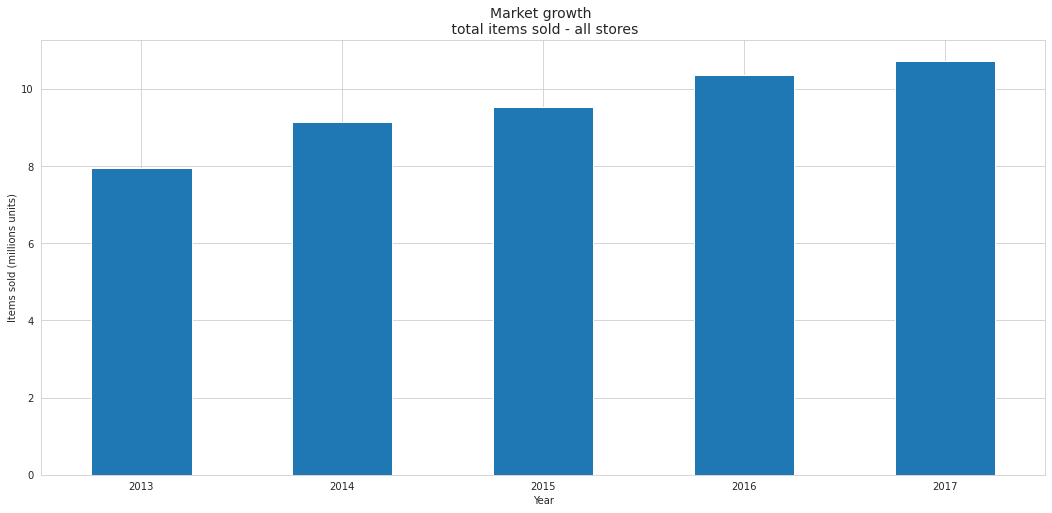

In [20]:
plt.figure(figsize=(18,8))
sns.set_style('whitegrid')
sales_total_by_year.plot(kind='bar', rot=0, ylabel='Items sold (millions units)', xlabel='Year')
plt.title('Market growth \n total items sold - all stores', fontsize=14)
plt.show()

### [Q2] *Which are the best stores?*

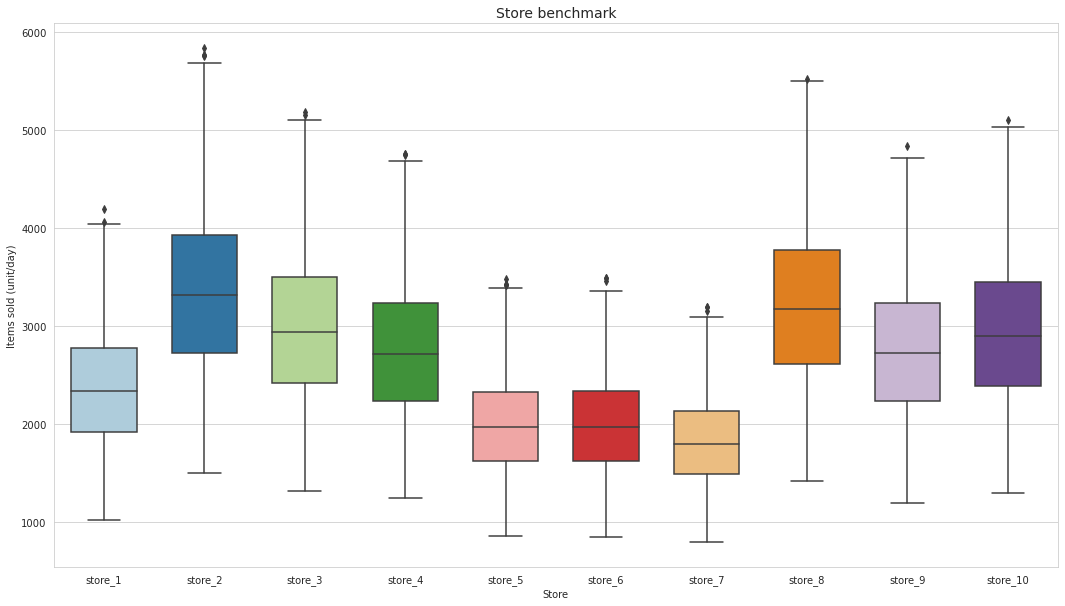

In [21]:
fig = plt.figure(figsize=(18,10))
ax  = fig.add_subplot()
sns.set_style('whitegrid')
sns.boxplot(x="variable", y="value", data=pd.melt(sales_by_store), palette='Paired', width=0.65)
plt.title('Store benchmark', fontsize=14)
plt.xlabel('Store')
plt.ylabel('Items sold (unit/day)')
plt.show()

### [Q3] *Are sales between stores correlated?*

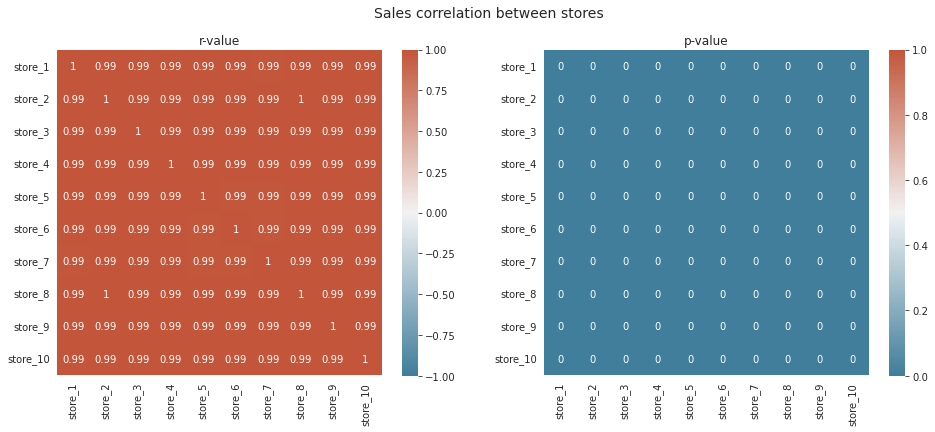

In [22]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)

mat_coeff = []
mat_pval = []
for i in list(range(len(sales_by_store.columns))):
    row_coeff = []
    row_pval = []
    for j in list(range(len(sales_by_store.columns))):
        temp = stats.pearsonr(sales_by_store.iloc[:,i],sales_by_store.iloc[:,j])
        row_coeff.append(temp[0])
        row_pval.append(temp[1])
    mat_coeff.append(row_coeff)
    mat_pval.append(row_pval)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(mat_coeff, annot=True,  cmap=cmap,square=True,ax=axes[0],annot_kws={"size":10}, vmin=-1, vmax=1, xticklabels=sales_by_store.columns, yticklabels=sales_by_store.columns)
axes[0].set_title('r-value')
sns.heatmap(mat_pval, annot=True,  cmap=cmap,square=True,ax=axes[1],annot_kws={"size":10}, vmin=0, vmax=1, xticklabels=sales_by_store.columns, yticklabels=sales_by_store.columns)
axes[1].set_title('p-value')
fig.suptitle('Sales correlation between stores', fontsize=14)
plt.show()

### [Q4] *Which is the best month? And the best weekday?*

In [23]:
sales_groupby = sales_df[['date','store','sales']].groupby(['date','store']).sum()
sales_groupby['month'] = (sales_groupby.index).to_series().map(lambda x : x[0].month)
sales_groupby['weekday'] = (sales_groupby.index).to_series().map(lambda x : x[0].isoweekday())
display(sales_groupby)

sales  month  weekday
date       store                       
2013-01-01 1       1316      1        2
           2       1742      1        2
           3       1588      1        2
           4       1423      1        2
           5       1032      1        2
...                 ...    ...      ...
2017-12-31 6       2009     12        7
           7       1831     12        7
           8       3205     12        7
           9       2774     12        7
           10      2939     12        7

[18260 rows x 3 columns]

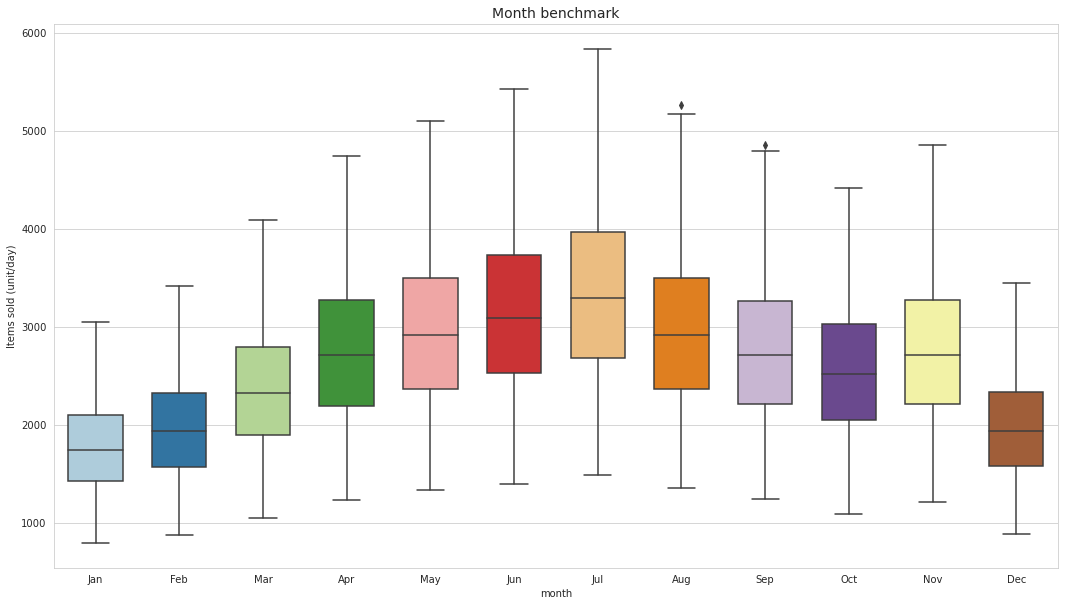

In [24]:
fig = plt.figure(figsize=(18,10))
ax  = fig.add_subplot()
sns.set_style('whitegrid')
sns.boxplot(data=sales_groupby, x='month', y='sales', palette='Paired', width=0.65)
plt.title('Month benchmark', fontsize=14)
plt.ylabel('Items sold (unit/day)')
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.show()

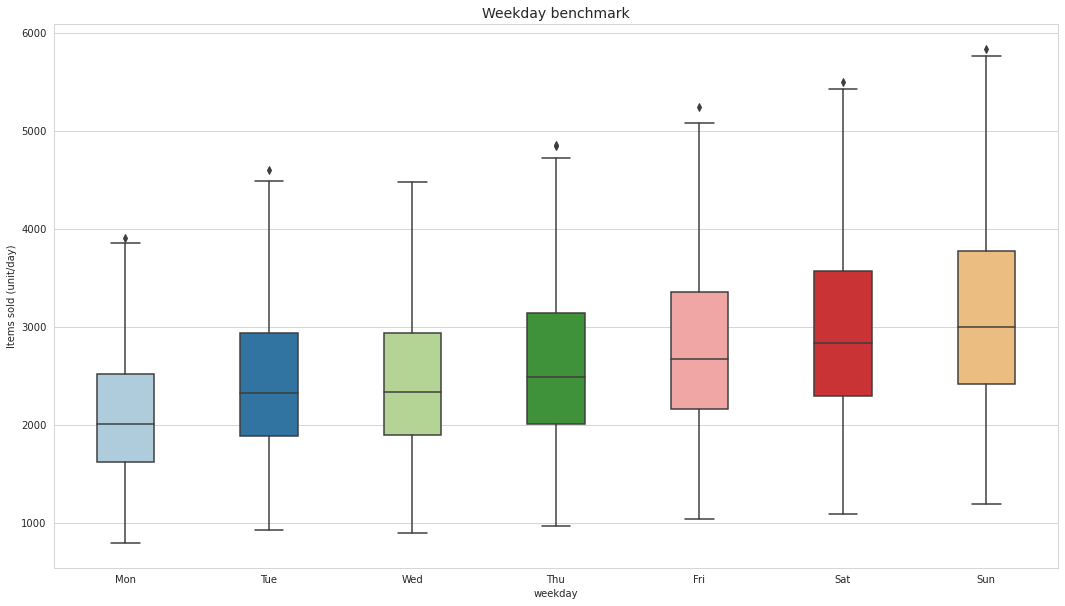

In [25]:
fig = plt.figure(figsize=(18,10))
ax  = fig.add_subplot()
sns.set_style('whitegrid')
sns.boxplot(data=sales_groupby, x='weekday', y='sales', palette='Paired', width=0.4)
plt.title('Weekday benchmark', fontsize=14)
plt.ylabel('Items sold (unit/day)')
ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.show()

### [Q5] *Which are the top 15 best selling items?*

In [26]:
sales_groupby_item = sales_df[['item','sales']].groupby(['item']).sum()
sales_groupby_item = sales_groupby_item.sort_values(by='sales', ascending=False)
sales_groupby_item['sales (millions units)'] = round(sales_groupby_item['sales']/1000000,3)
top_15_items = sales_groupby_item.head(15)
top_15_items.index = top_15_items.index.astype(str)
display(top_15_items)

,sales,sales (millions units)
item,,
15,1607442,1.607
28,1604713,1.605
13,1539621,1.540
18,1538876,1.539
25,1473334,1.473
45,1471467,1.471
38,1470330,1.470
22,1469971,1.470
36,1406548,1.407


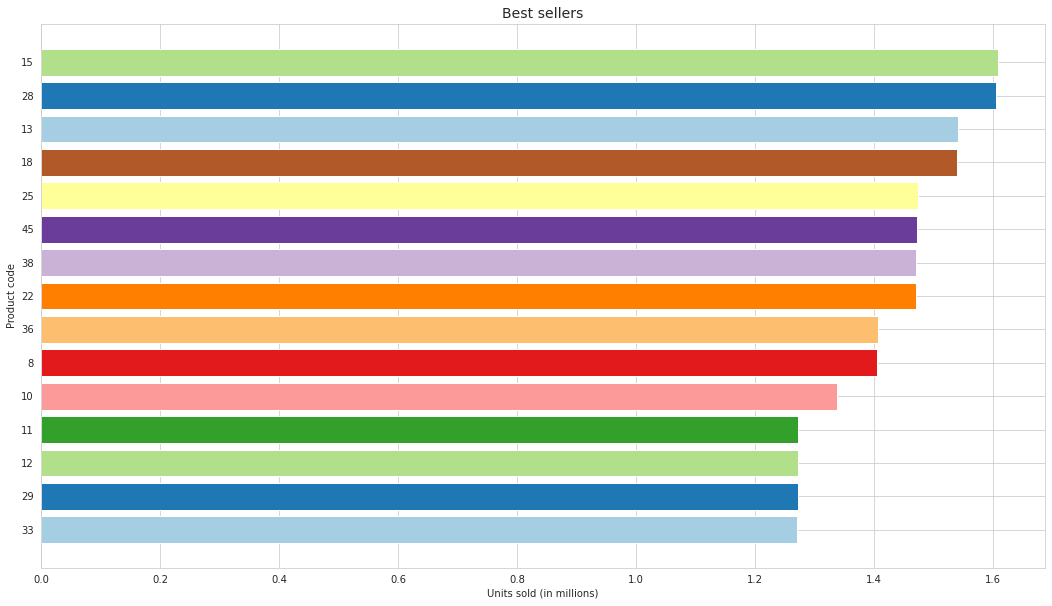

In [27]:
top_15_items = top_15_items.sort_values(by='sales', ascending=True)
plt.figure(figsize=(18,10))
sns.set_style('whitegrid')
plt.barh(top_15_items.index, top_15_items['sales (millions units)'], color= sns.color_palette("Paired"))
plt.title('Best sellers', fontsize=14)
plt.xlabel('Units sold (in millions)')
plt.ylabel('Product code')
plt.show()

### [Q6] *Are top 15 items sales associated to specifc stores?*

In [28]:
sales_store_item = pd.pivot_table(data=sales_df, index='item', columns='store', values='sales', aggfunc='sum')
sales_store_item.index = sales_store_item.index.astype(str)
sales_store_item.columns = sales_store_item.columns.astype(str)
sales_store_item_top15 = sales_store_item.loc[top_15_items.index]
display(sales_store_item_top15)

store,1,2,3,4,5,6,7,8,9,10
item,,,,,,,,,,
33,114592,163083,144490,133989,97065,96180,88260,155840,133590,143094
29,115196,162466,145499,133743,96368,97238,88594,155633,133641,142862
12,115465,163154,144407,133486,96868,96545,88650,156386,134038,142535
11,115436,163080,144786,134030,96742,96836,88366,156118,133606,142925
10,121163,171822,152266,140689,101361,101462,93412,164008,140794,150156
8,126856,180939,159807,147577,106941,106612,98100,172486,148431,157359
36,126560,180355,160247,147955,106941,107482,97792,172312,148724,158180
22,132899,188096,167710,154542,112095,111442,102299,180618,154960,165310
38,133927,188533,167758,154433,112022,111967,101927,180679,154559,164525


In [29]:
stat, p, dof, expected = chi2_contingency(sales_store_item_top15)
print('dof=%d' % dof)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))

# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

dof=126
probability=0.950, critical=153.198, stat=105.284
significance=0.050, p=0.910
Independent (fail to reject H0)


# Focus on Time Series [Total items sold per store]

In [30]:
descriptive_stat = sales_by_store.describe().T

Q1 = sales_by_store.quantile(0.25)
Q3 = sales_by_store.quantile(0.75)
IQR = Q3 - Q1

outlier_lower_count = (sales_by_store < (Q1 - 1.5 * IQR)).sum()
outlier_upper_count = (sales_by_store > (Q3 + 1.5 * IQR)).sum()
outlier_total_count = outlier_lower_count + outlier_upper_count

descriptive_stat['range']=descriptive_stat['max']-descriptive_stat['min']
descriptive_stat['IQR']=descriptive_stat['75%']-descriptive_stat['25%']
descriptive_stat['outlier_lower_count'] = outlier_lower_count
descriptive_stat['outlier_upper_count'] = outlier_upper_count
descriptive_stat['outlier_total_count'] = outlier_total_count

display(round(descriptive_stat,2))

,count,mean,std,min,25%,50%,75%,max,range,IQR,outlier_lower_count,outlier_upper_count,outlier_total_count
store_1,1826.0,2363.42,583.18,1012.0,1919.25,2339.5,2771.75,4199.0,3187.0,852.50,0,2,2
store_2,1826.0,3351.66,824.95,1496.0,2724.50,3310.5,3929.00,5839.0,4343.0,1204.50,0,4,4
store_3,1826.0,2976.53,732.75,1313.0,2420.25,2937.5,3502.00,5183.0,3870.0,1081.75,0,2,2
store_4,1826.0,2745.15,675.62,1241.0,2231.25,2708.0,3231.75,4757.0,3516.0,1000.50,0,3,3
store_5,1826.0,1988.51,490.33,856.0,1618.25,1970.5,2328.25,3475.0,2619.0,710.00,0,4,4
store_6,1826.0,1986.68,488.84,845.0,1624.00,1963.0,2334.75,3488.0,2643.0,710.75,0,3,3
store_7,1826.0,1818.19,448.00,790.0,1482.00,1796.5,2134.75,3197.0,2407.0,652.75,0,3,3
store_8,1826.0,3207.10,789.40,1416.0,2607.00,3174.5,3772.00,5521.0,4105.0,1165.00,0,1,1
store_9,1826.0,2752.45,680.48,1194.0,2234.50,2719.5,3235.75,4836.0,3642.0,1001.25,0,1,1
store_10,1826.0,2935.46,722.70,1288.0,2382.00,2899.0,3448.75,5105.0,3817.0,1066.75,0,1,1


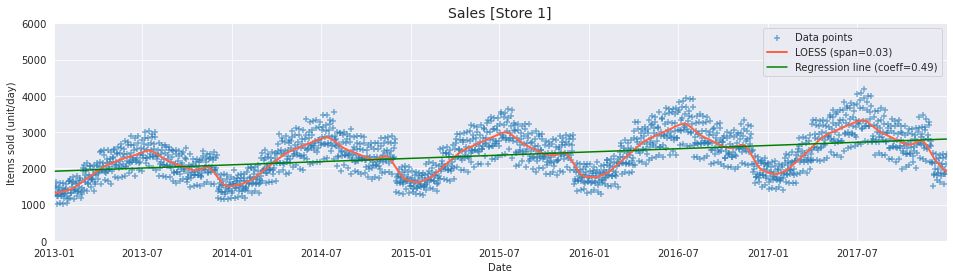

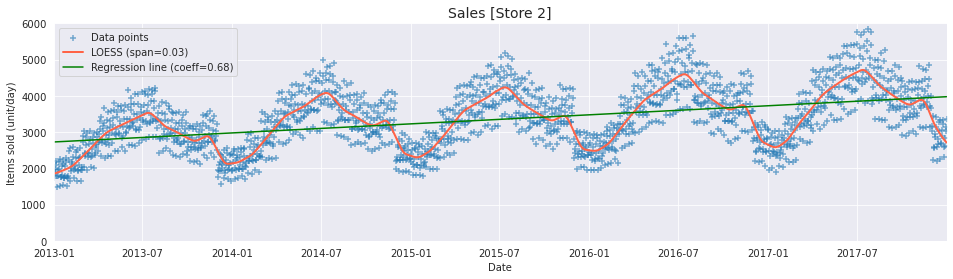

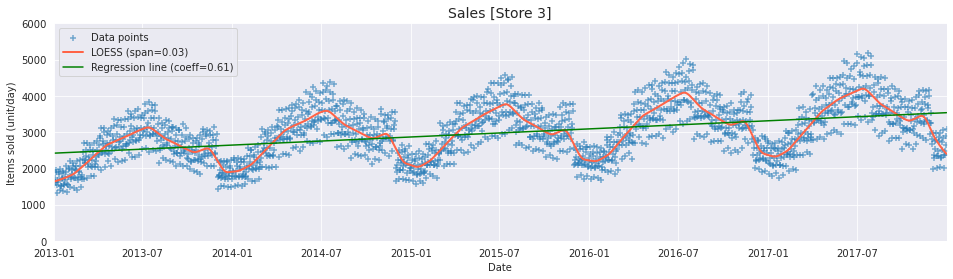

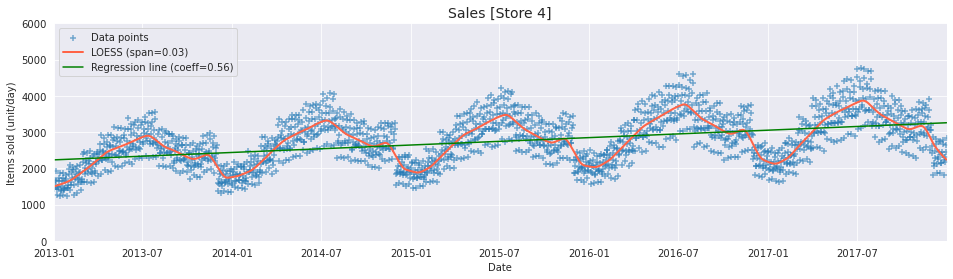

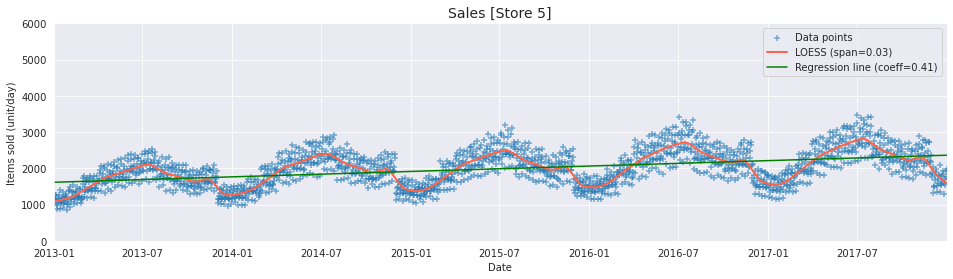

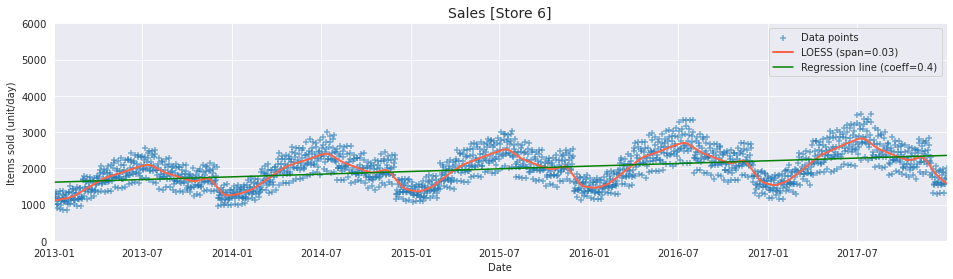

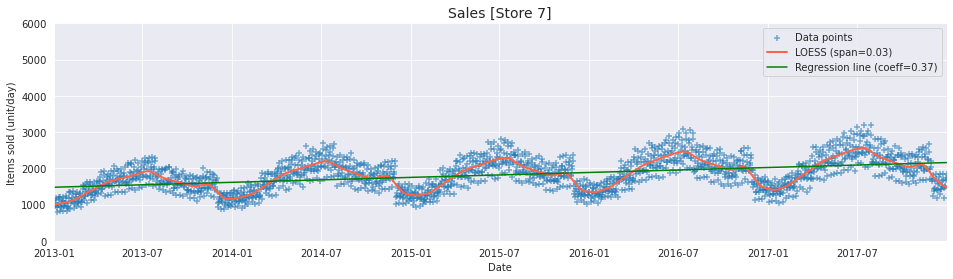

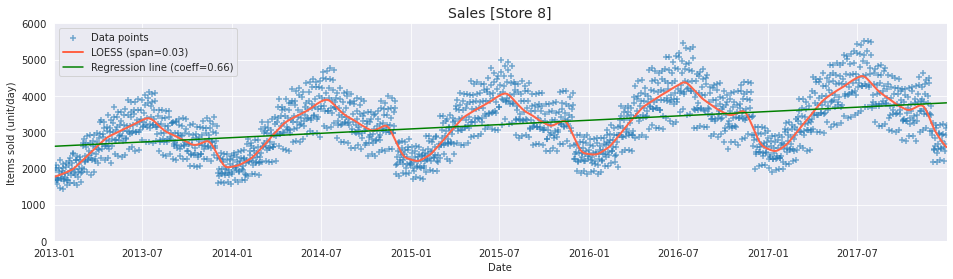

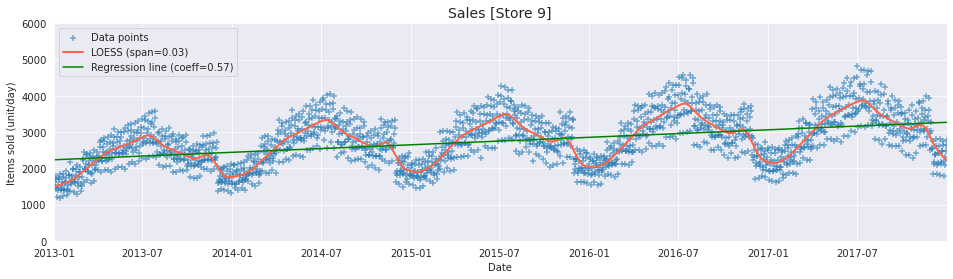

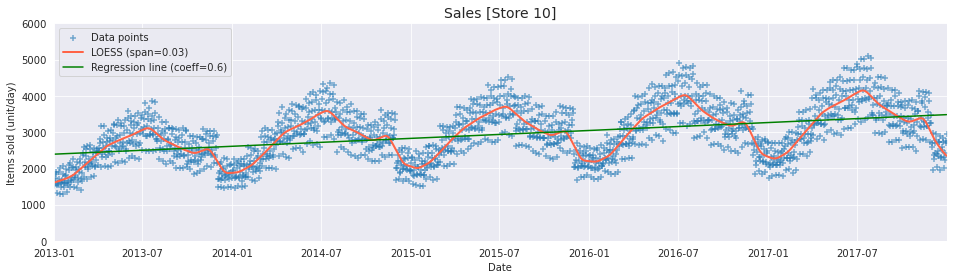

In [31]:
for store in sales_by_store.columns:
    store_number = store.split('_')[1]
    plotTS(sales_by_store, column=store, custom_ylim=(0,6000), title='Sales [Store {}]'.format(store_number), xlabel='Date', ylabel='Items sold (unit/day)')

Very high correlation (almost perfect) between sales in different stores and the same time pattern suggest that the data is likely to be synthetic. This 10 time series are kind of the same but with different trend and level. 

# In depth analysis [Store 2]

## Graphical inspection

In [32]:
store2_ts = pd.DataFrame(sales_by_store['store_2'])

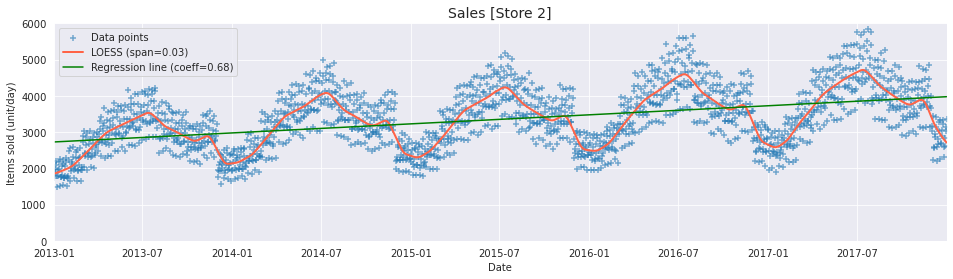

In [33]:
plotTS(store2_ts, column='store_2', custom_ylim=(0,6000), figsize=(16,4), title='Sales [Store 2]', xlabel='Date', ylabel='Items sold (unit/day)')

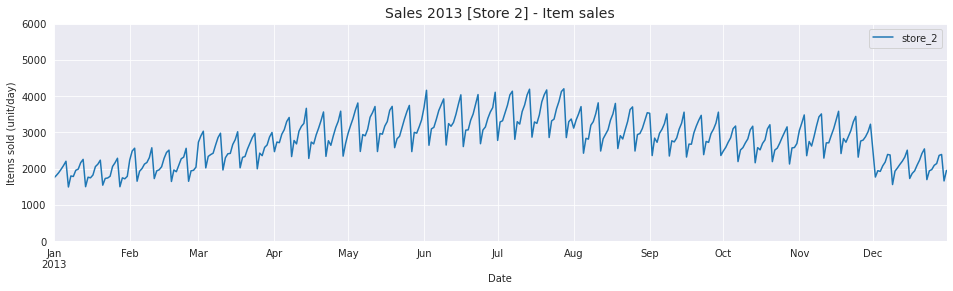

In [34]:
fig = store2_ts[0:365].plot(figsize=(16,4), title='Sales 2013 [Store 2] - Item sales')
fig.axes.title.set_size(14)
plt.xlabel('Date')
plt.ylabel('Items sold (unit/day)')
plt.ylim(0,6000)
plt.show()

**Impressions from plots:**

From a graphical point of view, the time series I am studying shows some interesting characteristics that may be useful in defining the next steps. The time series has a non-stationary nature with a consistent increasing trend, but at the same time it doesn't show breakpoints. There is graphical evidence of seasonality, in particular of both a weekly pattern and an annual cycle (also suggested by the boxplots of the exploratory analysis). It also seems to present the typical behavior that can be observed in most of the data relating to the sales of products in which as the number of units sold increases, so does the variance. If confirmed this might configure a situation where the trend is additive and seasonality multiplicative.

## Mathematical and statistical evidence

To test the graphical intuitions and gain other insights the following steps have been carried on:
1. Stationarity tests for having a statistical evidence of non stationarity, but also evidence of trend stationarity.
2. Power Spectral Density for seasonality (and cycle) investigation
3. Ljung-Box and Breusch-Godfrey test for statistical evidence of autocorrelation (alongiside Autocorrelation and Partial-Autocorrelation plots)
3. Decomposition and residuals analysis. In particular I will apply an additive model in order to verify, by studying the residuals, if the variance vary over time. If this is the case I will expect to find heteroscedasticity in the residuals (that will be tested with appropriate statistical tests).

### Stationarity

In [35]:
checkStationarity(store2_ts['store_2'], kpss_type='c')

*** ADF Test ***
ADF Statistic:  -3.0125705286097895
p-value:  0.03373703073332937
Interpretation: The time series is stationary (Ha)

*** KPSS Test ***
KPSS Statistic: 1.9938451446626928
p-value:  0.01
Interpretation: The time series is not stationary (Ha)


In [36]:
checkStationarity(store2_ts['store_2'], kpss_type='ct')

*** ADF Test ***
ADF Statistic:  -3.0125705286097895
p-value:  0.03373703073332937
Interpretation: The time series is stationary (Ha)

*** KPSS Test ***
KPSS Statistic: 0.07711283395126454
p-value:  0.1
Interpretation: The time series is trend stationary (Ho)


### Power Spectral Density

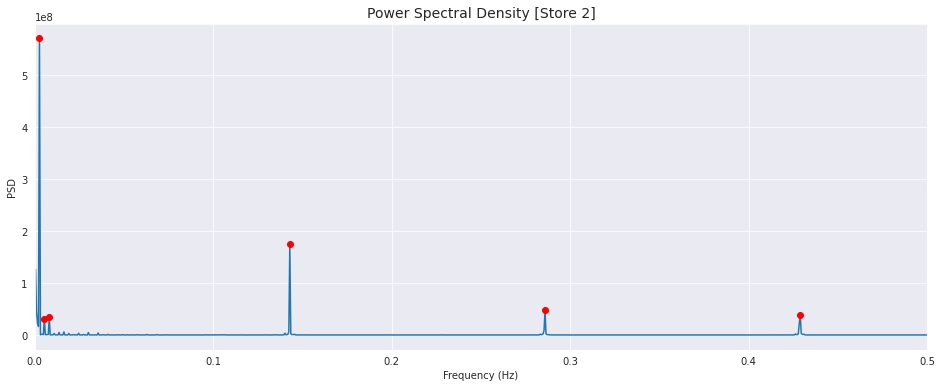

,Freq,Power,Period (days)
0,0.002738,5.703831e+08,365.200000
1,0.005476,3.168921e+07,182.600000
2,0.008215,3.429607e+07,121.733333
3,0.142935,1.741782e+08,6.996169
4,0.285871,4.768970e+07,3.498084
5,0.428806,3.846926e+07,2.332056


In [37]:
Fs = 1
f_per, Pxx_per = signal.periodogram(store2_ts['store_2'],Fs,window=None,return_onesided=True,scaling='density')
sns.set_style('darkgrid')
plt.figure(figsize=(16,6))
plt.title('Power Spectral Density [Store 2]', fontsize=14)
plt.plot(f_per[1:],Pxx_per[1:])
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')

f_per = f_per[1:]
Pxx_per = Pxx_per[1:]
peaks = signal.find_peaks(Pxx_per[ f_per >= 0], prominence=np.quantile(Pxx_per, 0.99))[0]
peaks_freq = f_per[peaks]
peaks_power = Pxx_per[peaks]
plt.plot(peaks_freq, peaks_power, 'ro')
plt.xlim(0,0.5)
plt.show()

data = {'Freq':peaks_freq, 'Power':peaks_power}
df_PSD = pd.DataFrame(data)
df_PSD['Period (days)'] = 1/df_PSD['Freq']
display(df_PSD)

PSD confirmed the hypothesis of both an annual cycle (365 days) and a weekly seasonality (7 days).

### Autocorrelation

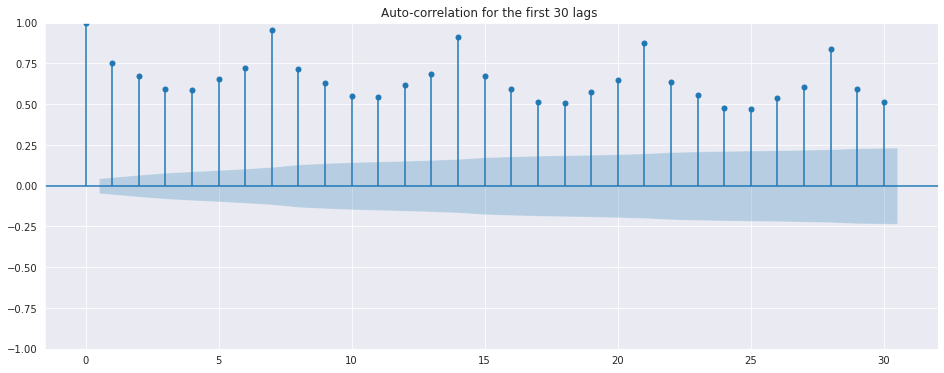

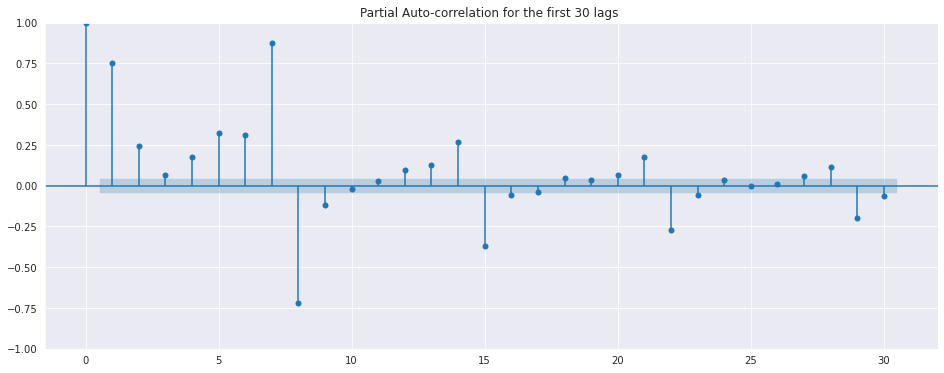

*** Ljung-Box Test [30 lags] ***
Q:  23490.213719382467
p-value:  0.0
Interpretation: The residuals are not independently distributed, they exhibit serial correlation (Ha)

*** Breusch-Godfrey Test [30 lags] ***
Lagrange multiplier statistic:  1767.3938203589983
p-value:  0.0
Interpretation: There exists autocorrelation at some order less than or equal to p (Ha)


In [38]:
autocorrelationPlot(store2_ts['store_2'], lags=30)
checkAutorcorrelation(store2_ts['store_2'].values, lags=30)

### Decomposition and analysis of residuals

#### Decomposition

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [40]:
#extracting weekly seasonality
sd_week = seasonal_decompose(store2_ts['store_2'], model='additive', period=7, two_sided=True)
#extracting yearly seasonality from time series adjusted by weekly seasonality
sd_year = seasonal_decompose(store2_ts['store_2'] -  sd_week.seasonal, model='additive', period=365, two_sided=True)

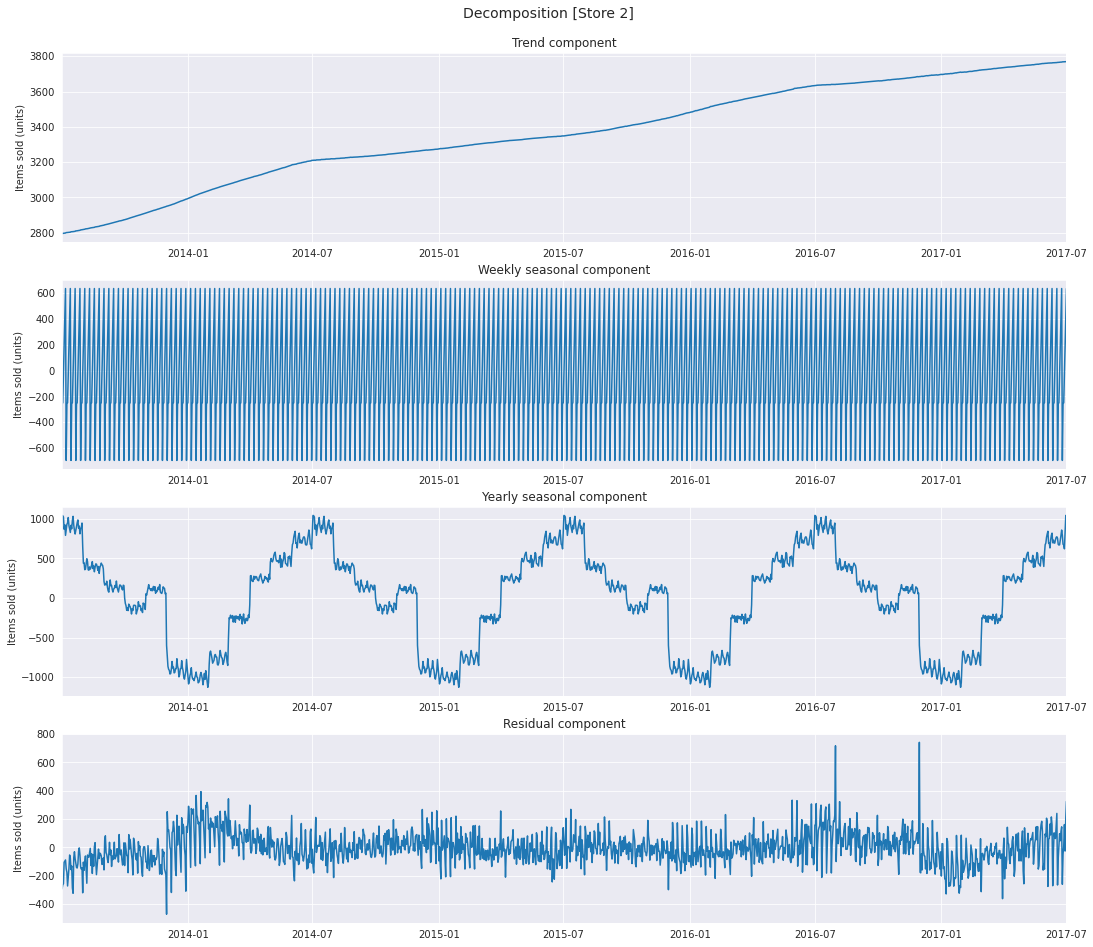

In [41]:
f, axes = plt.subplots(4,1,figsize=(18,16))
plt.suptitle('Decomposition [Store 2]', y=0.92, fontsize=14)

#plotting trend component
axes[0].plot(sd_year.trend)
axes[0].set_title('Trend component', fontdict={'fontsize': 12})

#plotting weekly seasonal component
axes[1].plot(sd_week.seasonal)
axes[1].set_title('Weekly seasonal component', fontdict={'fontsize': 12})

#plotting yearly seasonal component
axes[2].plot(sd_year.seasonal)
axes[2].set_title('Yearly seasonal component', fontdict={'fontsize': 12})

#plotting residual of decomposition
axes[3].plot(sd_year.resid)
axes[3].set_title('Residual component', fontdict={'fontsize': 12})

for a in axes:
    a.set_ylabel('Items sold (units)')
    a.set_xlim(sd_year.trend.dropna().index[0], sd_year.trend.dropna().index[-1])

#showing chart
plt.show()

#### Decomposition residuals

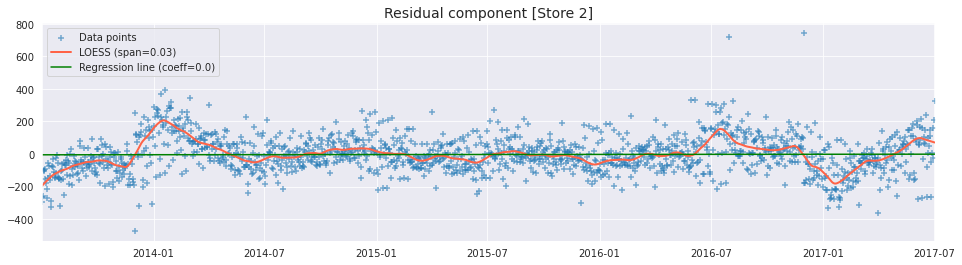

In [42]:
decomp_residuals = pd.DataFrame(sd_year.resid.dropna())
plotTS(decomp_residuals, column='resid', figsize=(16,4), title='Residual component [Store 2]')

##### Checking normality (residuals)

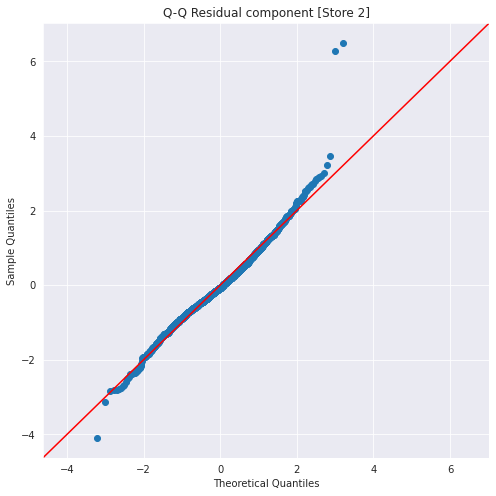

*** Shapiro-Wilk Test ***
W:  0.9790919423103333
p-value:  9.591681832468724e-14
Interpretation: the data was not drawn from a normal distribution (Ha)

*** Jarque-Bera Test ***
Jarque-Bera JB:  439.0449270959395
p-value:  0.0
Interpretation: the data was not drawn from a normal distribution (Ha)

*** D’Agostino-Pearson Test ***
k2:  [138.78736085]
p-value:  [7.28966403e-31]
Interpretation: the data was not drawn from a normal distribution (Ha)

----------------------------------------------------------------------
Skewness:  [0.46197912]
Kurtosis :  [2.52063584]


In [43]:
qqPlot(decomp_residuals['resid'], title='Residual component [Store 2]')
checkNormality(decomp_residuals)

##### Checking stationarity (residuals)

In [44]:
checkStationarity(decomp_residuals, kpss_type='c')

*** ADF Test ***
ADF Statistic:  -3.1847661813003927
p-value:  0.020883580289399545
Interpretation: The time series is stationary (Ha)

*** KPSS Test ***
KPSS Statistic: 0.17962073709193754
p-value:  0.1
Interpretation: The time series is stationary (Ho)


##### Checking homoscedasticity (residuals)

Since Breusch–Pagan test is sensitive to departures from normality (like the one in the residuals) I choose the Koenker test (studentized Breusch-Pagan).

https://eprints.lancs.ac.uk/id/eprint/149534/2/daryanto_heteros_tqmp_v008.pdf

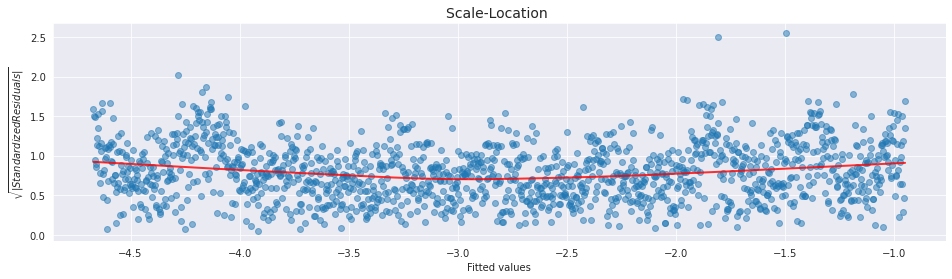

*** Koenker Test ***
Lagrange multiplier statistic:  0.6818513537880388
p-value:  0.4089499452292398
Interpretation: Homoscedasticity is present, the residuals are distributed with equal variance (Ho)


In [45]:
scalelocationPlot(decomp_residuals['resid'], figsize=(16,4))
checkHomoscedasticity(decomp_residuals, robust=True)

##### Checking autocorrelation (residuals)

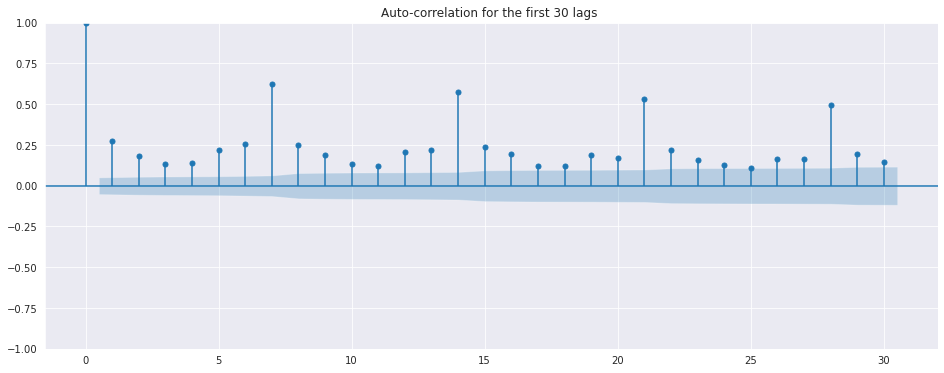

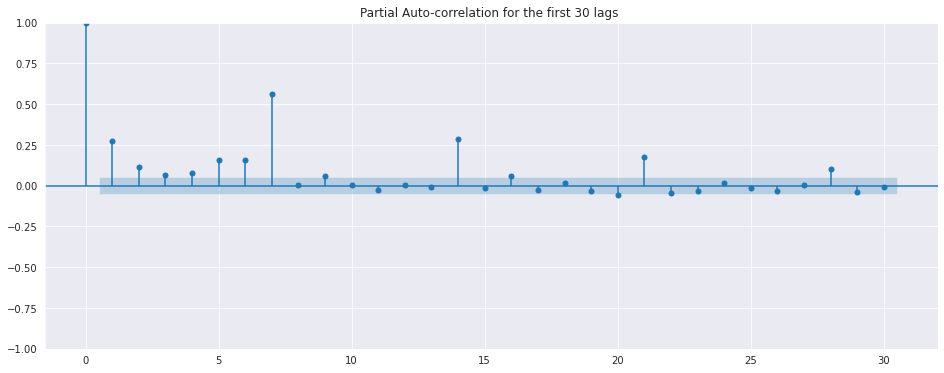

*** Ljung-Box Test [30 lags] ***
Q:  3135.186437006601
p-value:  0.0
Interpretation: The residuals are not independently distributed, they exhibit serial correlation (Ha)

*** Breusch-Godfrey Test [30 lags] ***
Lagrange multiplier statistic:  731.4451297805144
p-value:  1.3468743203912925e-134
Interpretation: There exists autocorrelation at some order less than or equal to p (Ha)


In [46]:
autocorrelationPlot(decomp_residuals['resid'], lags=30)
checkAutorcorrelation(decomp_residuals, lags=30)

Conclusioni sulle evidenze raccolte

## Models comparison

The main goal of this section is to build a forecasting model that can effectively capture both annual and weekly patterns and provide a valid estimate of future values.

The following approaches will be tested in detail:
* **SARIMAX with Fourier Terms** as exogenous variables.
* **Double Seasonal Holt-Winters**
* **TBATS** (Exponential smoothing state space model with Box-Cox transformation, ARMA errors, Trend and Seasonal components)
* **Prophet** (Facebook)

The models will be *trained* on a training set containing sales from *2013-01-01 to 2017-10-31* and *tested* on the remaining actual data (*2017-11-01 to 2017-12-31*). 

Performance will be evaluated by using 
* **MSE**
* **MAE**
* **MAPE**

### Train-Test Split

In [47]:
train = store2_ts['store_2'][:'2017-10-31']
test = store2_ts['store_2']['2017-11-01':]

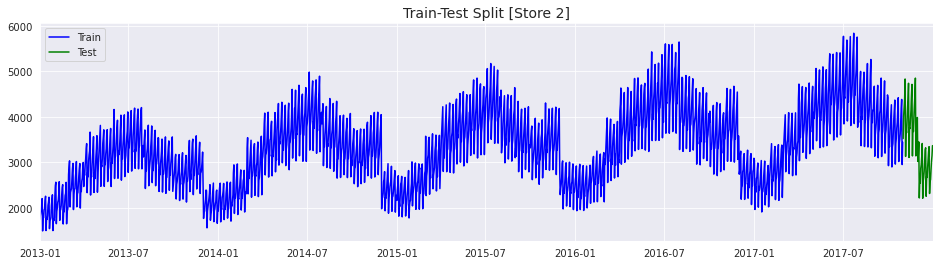

In [48]:
plt.figure(figsize=(16,4))
plt.plot(train, color='blue', label='Train')
plt.plot(test, color='green', label='Test')
plt.xlim(train.index[0],test.index[-1])
plt.title('Train-Test Split [Store 2]', fontsize=14)
plt.legend()
plt.show()

### SARIMAX with Fourier Terms

#### Mathematical description

$ y_t = a + \sum_{k=1}^K \left[ \alpha_k\sin(2\pi kt/m) + \beta_k\cos(2\pi kt/m)\right] + N_t $

where $N_t$ is a SARIMA process and $K$ the number of Fourier terms.

#### Building the model

*Computing Fourier Terms*

Since the SARIMA model that I want to build allows me to take into account only one seasonality I have to add terms to the model in order to include the annual cycle. In this case the annual cycle is modeled through the addition of Fourier terms which are used as external regressors. 

In [49]:
from pmdarima.preprocessing import FourierFeaturizer

In [50]:
trans = FourierFeaturizer(365.25, 2)
y_prime, X = trans.fit_transform(store2_ts['store_2'])
X.index = store2_ts['store_2'].index
display(X)

Y_train = store2_ts['store_2'][:'2017-10-31']
X_train = X[:'2017-10-31']
Y_test = store2_ts['store_2']['2017-11-01':]
X_test = X['2017-11-01':]

,FOURIER_S365-0,FOURIER_C365-0,FOURIER_S365-1,FOURIER_C365-1
date,,,,
2013-01-01,0.017202,0.999852,0.034398,0.999408
2013-01-02,0.034398,0.999408,0.068755,0.997634
2013-01-03,0.051584,0.998669,0.103031,0.994678
2013-01-04,0.068755,0.997634,0.137185,0.990545
2013-01-05,0.085906,0.996303,0.171177,0.985240
...,...,...,...,...
2017-12-27,-0.073045,0.997329,-0.145700,0.989329
2017-12-28,-0.055879,0.998438,-0.111583,0.993755
2017-12-29,-0.038696,0.999251,-0.077333,0.997005


*Finding the best model*

In [51]:
from pmdarima import auto_arima

In [52]:
arima_model = auto_arima(Y_train, start_p=1, start_q=1,
                         max_p=7, max_d=2, max_q=7, # maximum p d q
                         seasonal=True,   # Seasonality
                         m=7,              # Seasonality type (weekly)
                         max_P=7, max_D=2, max_Q=7, # maximum P D Q
                         suppress_warnings=True, 
                         n_jobs = -1,
                         maxiter = 50,
                         information_criterion = 'aic',
                         random_state=42,
                         trace=True,
                         exogenous=X_train)
print(arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=4.17 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=27461.312, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=inf, Time=3.45 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=1.33 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=27459.327, Time=0.50 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=inf, Time=1.30 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=25868.661, Time=0.91 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=22268.047, Time=2.90 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=22266.607, Time=5.30 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=24980.614, Time=1.87 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=22264.473, Time=7.31 sec
 ARIMA(0,1,0)(3,0,2)[7] intercept   : AIC=inf, Time=5.18 sec
 ARIMA(0,1,0)(2,0,3)[7] intercept   : AIC=inf, Time=11.79 sec
 ARIMA(0,1,0)(1,0,3)[7] intercept   : AIC=22297.696, Time=10.

#### Checking the residuals

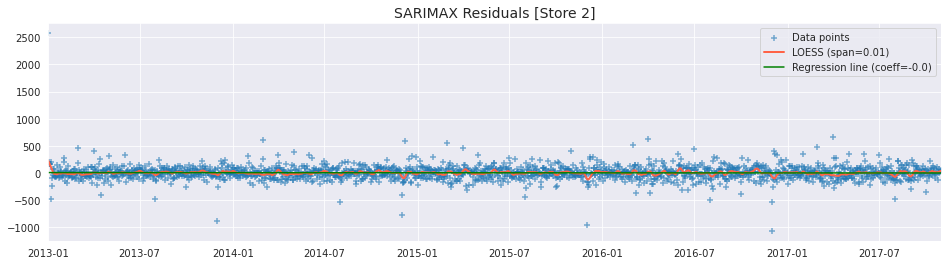

In [61]:
arima_resid = arima_model.arima_res_.resid
plotTS(pd.DataFrame(arima_resid, columns=['resid']), column='resid', figsize=(16,4), title='SARIMAX Residuals [Store 2]')

##### Checking normality (SARIMAX residuals)

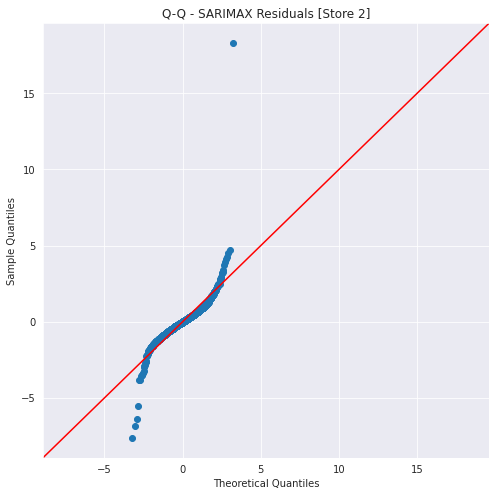

*** Shapiro-Wilk Test ***
W:  0.7979258298873901
p-value:  2.4396606263895065e-42
Interpretation: the data was not drawn from a normal distribution (Ha)

*** Jarque-Bera Test ***
Jarque-Bera JB:  351938.6490953963
p-value:  0.0
Interpretation: the data was not drawn from a normal distribution (Ha)

*** D’Agostino-Pearson Test ***
k2:  1473.4021953954973
p-value:  0.0
Interpretation: the data was not drawn from a normal distribution (Ha)

----------------------------------------------------------------------
Skewness:  3.026234362434803
Kurtosis :  68.91252176027004


In [65]:
qqPlot(arima_resid, title='- SARIMAX Residuals [Store 2]')
checkNormality(arima_resid)

##### Checking stationarity (SARIMAX residuals)

In [63]:
checkStationarity(arima_resid, kpss_type='c')

*** ADF Test ***
ADF Statistic:  -23.105540778450138
p-value:  0.0
Interpretation: The time series is stationary (Ha)

*** KPSS Test ***
KPSS Statistic: 0.054787615764889865
p-value:  0.1
Interpretation: The time series is stationary (Ho)


##### Checking homoscedasticity (SARIMAX residuals)

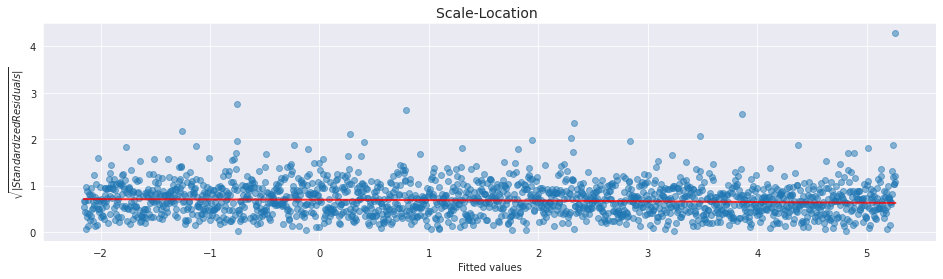

*** Koenker Test ***
Lagrange multiplier statistic:  1.3239291289095938
p-value:  0.2498881104745077
Interpretation: Homoscedasticity is present, the residuals are distributed with equal variance (Ho)


In [64]:
scalelocationPlot(arima_resid, figsize=(16,4))
checkHomoscedasticity(arima_resid, robust=True)

##### Checking autocorrelation (SARIMAX residuals)

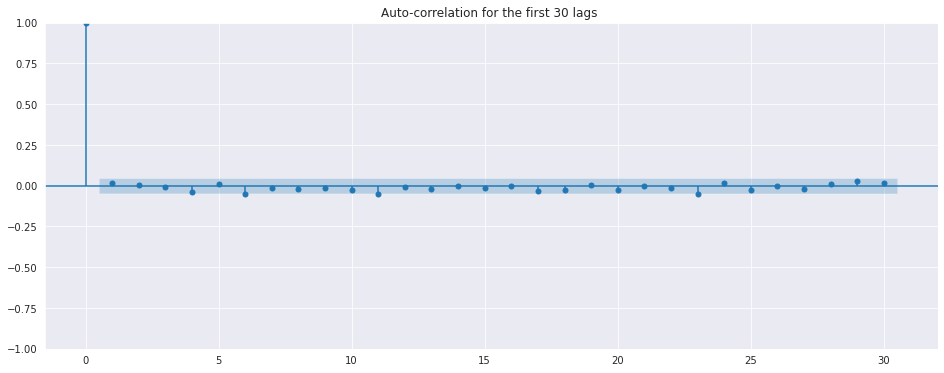

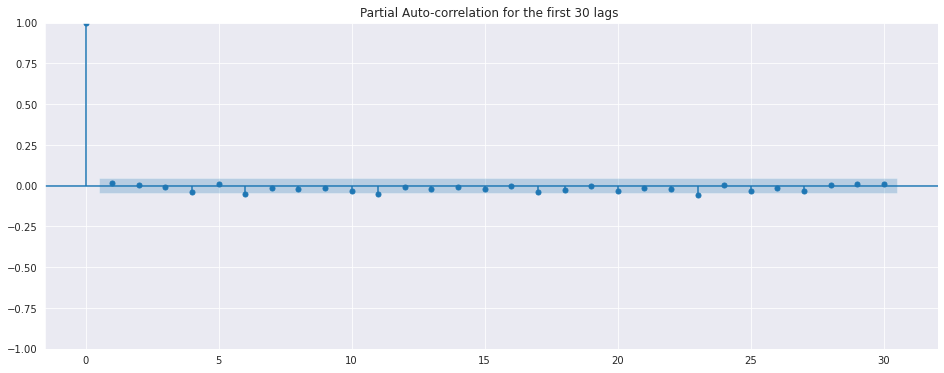

*** Ljung-Box Test [30 lags] ***
Q:  29.149860349362644
p-value:  0.5097345262733961
Interpretation: the residuals are independently distributed (Ho)

*** Breusch-Godfrey Test [30 lags] ***
Lagrange multiplier statistic:  33.08217832248869
p-value:  0.31898678469532366
Interpretation: there is no autocorrelation at any order less than or equal to p (Ho)


In [66]:
autocorrelationPlot(arima_resid, lags=30)
checkAutorcorrelation(arima_resid, lags=30)

##### ARIMA diagnostics (auto)

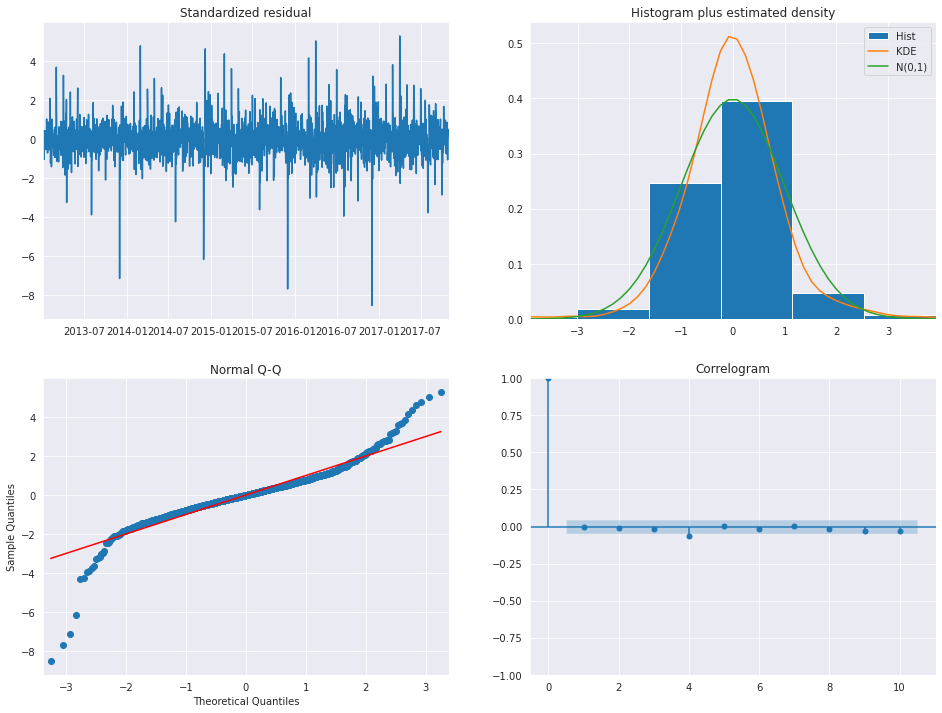

In [69]:
arima_model.plot_diagnostics(figsize=(16,12))
plt.show()

#### SARIMAX Prediction

In [70]:
y_pred_arima = arima_model.predict(n_periods=61, exogenous=X_test)
y_pred_arima = pd.Series(y_pred_arima)
y_pred_arima.index = test.index

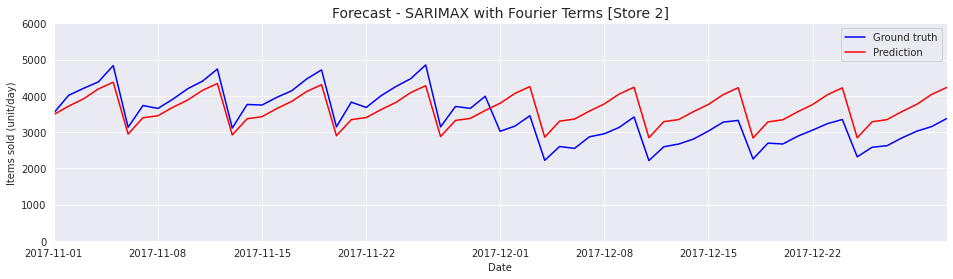

In [212]:
plt.figure(figsize=(16,4))
plt.plot(test, color='blue', label='Ground truth')
plt.plot(y_pred_arima, color='red', label='Prediction')
plt.title('Forecast - SARIMAX with Fourier Terms [Store 2]', fontsize=14)
plt.xlim(test.index[0],test.index[-1])
plt.xlabel('Date')
plt.ylabel('Items sold (unit/day)')
plt.ylim(0,6000)
plt.legend()
plt.show()

In [238]:
mse_sarimax = mean_squared_error(y_pred_arima,test.values)
mae_sarimax = mean_absolute_error(y_pred_arima,test.values)
mape_sarimax = mean_absolute_percentage_error(y_pred_arima,test.values)*100

print('SARIMAX model performance: ')
print('MSE: ', round(mse_sarimax,3))
print('MAE: ', round(mae_sarimax,3))
print('MAPE: ', round(mape_sarimax,3), '%')

SARIMAX model performance: 
MSE:  342571.209
MAE:  535.483
MAPE:  14.724 %


### Double Seasonal Holt-Winters

#### Mathematical description

<img src="https://i.imgur.com/MBqLsPe.png" width="300">

You can find more details about the Double Seasonal Holt-Winters in:
> Hyndman, R., Koehler, A. B., Ord, J. K., & Snyder, R. D. (2008). *Forecasting with exponential smoothing: the state space approach.* Springer Science & Business Media.

#### Building the model

In [76]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
utils = importr('utils')
pandas2ri.activate()
time_series=robjects.r('ts')
forecast_package=importr('forecast')

In [79]:
#converting the training data into an R time series object
r_times_series_data=time_series(train.values,frequency=1)

In [82]:
dshw_model=forecast_package.dshw(r_times_series_data,364,7, h=61)
dshw_model_summary = dshw_model.rx('model')
print(dshw_model_summary)

$model
$model$mape
[1] 2.293334

$model$mse
[1] 12996.26

$model$alpha
[1] 0.06698631

$model$beta
[1] 0.005312763

$model$gamma
[1] 0.06946449

$model$omega
[1] 0.4218238

$model$phi
[1] 0.3226915

$model$lambda
NULL

$model$l0
[1] 3251.965

$model$b0
[1] -0.6780808

$model$s10
  [1] 0.6908457 0.6939642 0.7112968 0.7483813 0.7502200 0.7281621 0.7184234
  [8] 0.7077052 0.7017449 0.7282208 0.7217608 0.7170937 0.7236630 0.7368920
 [15] 0.6973663 0.7005955 0.6773688 0.7324054 0.7380139 0.7304636 0.7477425
 [22] 0.6907641 0.7025396 0.7018869 0.7368167 0.7613697 0.7263866 0.7178790
 [29] 0.7239651 0.7216231 0.6992095 0.7166205 0.8288172 0.8314842 0.7858700
 [36] 0.7691893 0.7794623 0.7532091 0.8120705 0.8196537 0.8346016 0.7735904
 [43] 0.7679930 0.7712319 0.7732427 0.7792147 0.7947447 0.7954303 0.8120305
 [50] 0.7682331 0.7764215 0.7645969 0.8067544 0.7844643 0.7903836 0.7919183
 [57] 0.8094758 0.8036235 0.7459521 0.7711681 0.9784598 0.9885823 0.9543868
 [64] 0.9431158 0.9214324 0.9145007 

#### Checking the residuals

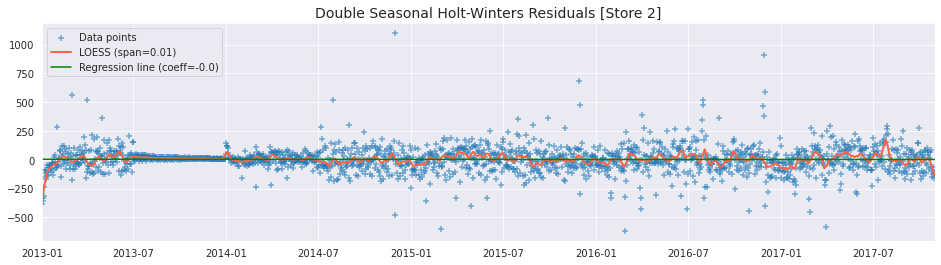

In [88]:
dshw_resid = np.array(dshw_model.rx('residuals'))
dshw_resid = pd.Series([x for x in dshw_resid[0]], index=train.index)
plotTS(pd.DataFrame(dshw_resid, columns=['resid']), column='resid', figsize=(16,4), title='Double Seasonal Holt-Winters Residuals [Store 2]')

##### Checking normality (Double Seasonal Holt-Winters residuals)

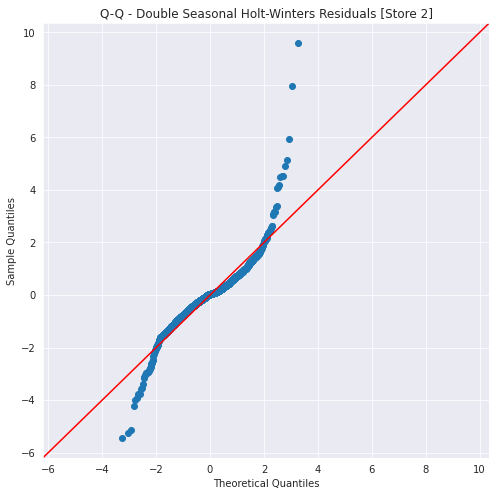

*** Shapiro-Wilk Test ***
W:  0.8905395269393921
p-value:  1.1887300498705618e-33
Interpretation: the data was not drawn from a normal distribution (Ha)

*** Jarque-Bera Test ***
Jarque-Bera JB:  9606.530130429905
p-value:  0.0
Interpretation: the data was not drawn from a normal distribution (Ha)

*** D’Agostino-Pearson Test ***
k2:  488.12594664082974
p-value:  1.0111077752258732e-106
Interpretation: the data was not drawn from a normal distribution (Ha)

----------------------------------------------------------------------
Skewness:  0.7921976160470734
Kurtosis :  11.318866124716905


In [91]:
qqPlot(dshw_resid, title='- Double Seasonal Holt-Winters Residuals [Store 2]')
checkNormality(dshw_resid)

##### Checking stationarity (Double Seasonal Holt-Winters residuals)

In [92]:
checkStationarity(dshw_resid, kpss_type='c')

*** ADF Test ***
ADF Statistic:  -40.352862534672006
p-value:  0.0
Interpretation: The time series is stationary (Ha)

*** KPSS Test ***
KPSS Statistic: 0.06412206006180818
p-value:  0.1
Interpretation: The time series is stationary (Ho)


##### Checking homoscedasticity (Double Seasonal Holt-Winters residuals)

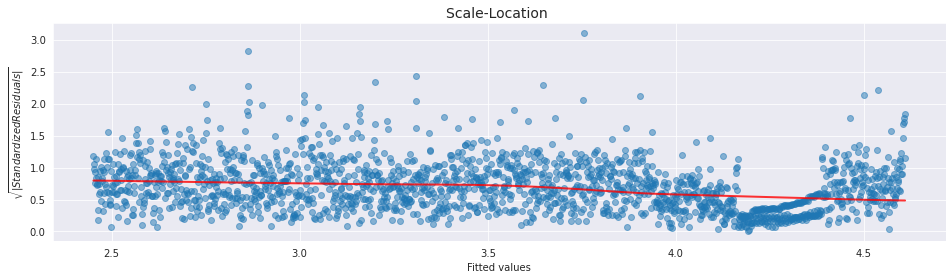

*** Koenker Test ***
Lagrange multiplier statistic:  9.652883656155664
p-value:  0.0018905457275767723
Interpretation: Heteroscedasticity is present, the residuals are not distributed with equal variance (Ha)


In [93]:
scalelocationPlot(dshw_resid, figsize=(16,4))
checkHomoscedasticity(dshw_resid, robust=True)

##### Checking autocorrelation (Double Seasonal Holt-Winters residuals)

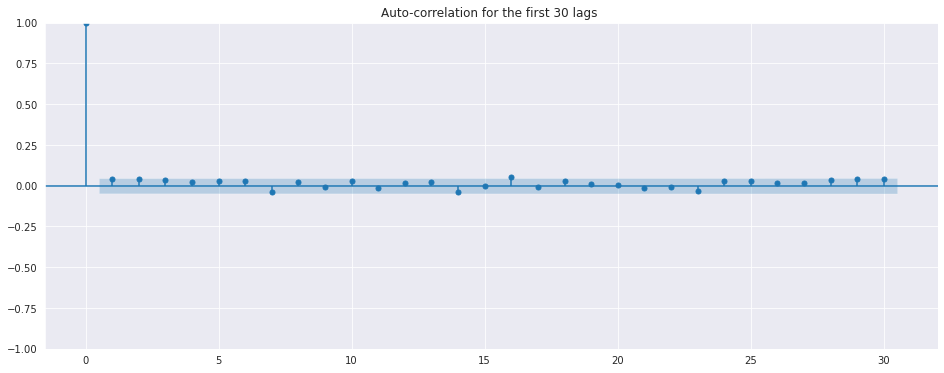

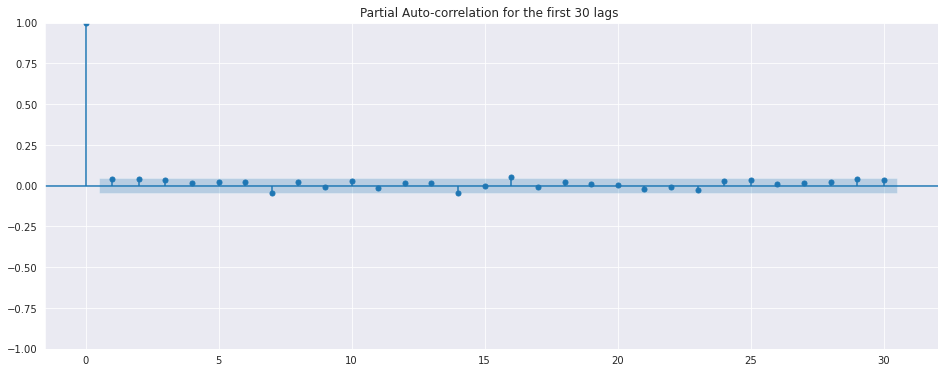

*** Ljung-Box Test [30 lags] ***
Q:  42.20936600969637
p-value:  0.06867121822233482
Interpretation: the residuals are independently distributed (Ho)

*** Breusch-Godfrey Test [30 lags] ***
Lagrange multiplier statistic:  38.59008145034176
p-value:  0.13518018136194646
Interpretation: there is no autocorrelation at any order less than or equal to p (Ho)


In [94]:
autocorrelationPlot(dshw_resid, lags=30)
checkAutorcorrelation(dshw_resid, lags=30)

#### Double Seasonal Holt-Winters Prediction

In [97]:
y_pred_dshw = np.array(dshw_model.rx('mean'))
y_pred_dshw = pd.Series([x for x in y_pred_dshw[0]], index =test.index)

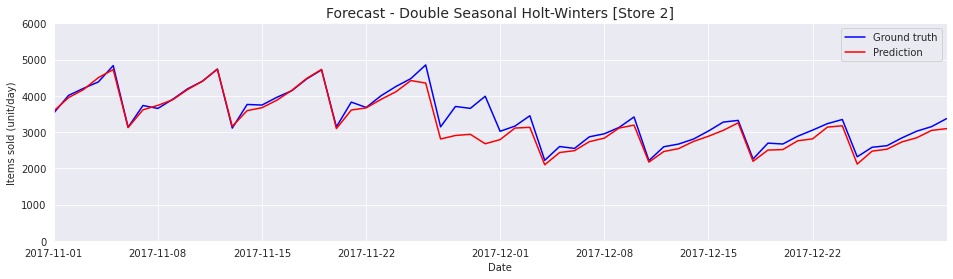

In [211]:
plt.figure(figsize=(16,4))
plt.plot(test, color='blue', label='Ground truth')
plt.plot(y_pred_dshw, color='red', label='Prediction')
plt.title('Forecast - Double Seasonal Holt-Winters [Store 2]', fontsize=14)
plt.xlim(test.index[0],test.index[-1])
plt.xlabel('Date')
plt.ylabel('Items sold (unit/day)')
plt.ylim(0,6000)
plt.legend()
plt.show()

In [239]:
mse_dshw = mean_squared_error(y_pred_dshw,test.values)
mae_dshw = mean_absolute_error(y_pred_dshw,test.values)
mape_dshw = mean_absolute_percentage_error(y_pred_dshw,test.values)*100

print('Double Seasonal Holt-Winters model performance: ')
print('MSE: ', round(mse_dshw,3))
print('MAE: ', round(mae_dshw,3))
print('MAPE: ', round(mape_dshw,3), '%')

Double Seasonal Holt-Winters model performance: 
MSE:  68673.663
MAE:  158.071
MAPE:  5.342 %


### TBATS

#### Mathematical description

<img src="https://i.imgur.com/kY6IqVn.png" width="300">
<img src="https://yintingchou.com/posts/2017-05-03-bats-and-tbats-model/tbats2.png" width="300">

where $i = i_{th}$ seasonality. If it is double seasonality then  $i = 1,2$.

You can find more details about the TBATS in:
> De Livera, A. M., Hyndman, R. J., & Snyder, R. D. (2011). *Forecasting time series with complex seasonal patterns using exponential smoothing.* Journal of the American statistical association, 106(496), 1513-1527.

#### Building the model

In [118]:
from tbats import TBATS

In [ ]:
tbats_model = TBATS(seasonal_periods=[7, 365.25], use_arma_errors=True)
tbats_fitted_model = tbats_model.fit(train.values)

In [120]:
print(tbats_fitted_model.summary())

Use Box-Cox: True
Use trend: False
Use damped trend: False
Seasonal periods: [  7.   365.25]
Seasonal harmonics [ 3 63]
ARMA errors (p, q): (2, 2)
Box-Cox Lambda 0.179500
Smoothing (Alpha): 0.134255
Seasonal Parameters (Gamma): [ 0.00151971  0.00063366 -0.00118173  0.00055163]
AR coefficients [-0.00118173  0.00055163]
MA coefficients [-0.11254968 -0.1879004 ]
Seed vector [ 1.74134011e+01 -5.61899266e-01 -6.45502023e-02  3.15166555e-01
 -1.10028363e-01  3.35890948e-01  1.84110557e-01 -1.02184211e+00
 -1.31826728e-01 -1.95607284e-01 -7.48504639e-02 -8.36177851e-02
  2.55110221e-02  7.16564235e-02  4.34508678e-02  4.60358280e-02
  5.48937616e-03  7.95415503e-02  9.92476718e-03 -8.18683465e-02
 -2.87455714e-02 -4.55224405e-02 -1.57339362e-02 -2.09320685e-02
  2.21744293e-02  3.00626235e-02  2.43628461e-02  1.42581708e-02
 -6.18958610e-03  2.88010331e-02  7.93995313e-03 -3.39994134e-02
 -2.03517810e-02 -3.11010863e-02 -9.98806880e-03 -6.78062859e-03
  1.76905287e-02  2.00376257e-02  2.04500

#### Checking the residuals

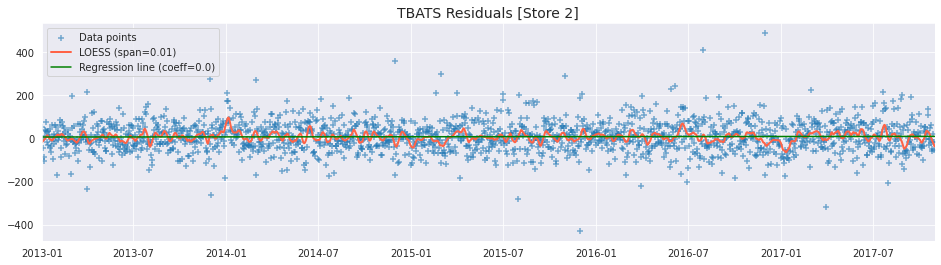

In [123]:
tbats_resid = pd.Series(tbats_fitted_model.resid, index =train.index)
plotTS(pd.DataFrame(tbats_resid, columns=['resid']), column='resid', figsize=(16,4), title='TBATS Residuals [Store 2]')

##### Checking normality (TBATS residuals)

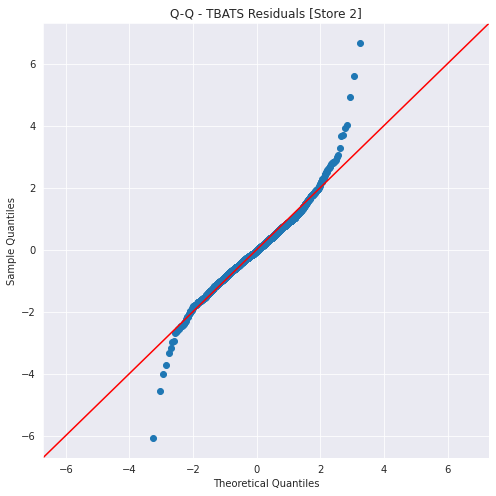

*** Shapiro-Wilk Test ***
W:  0.9718718528747559
p-value:  4.247667571230241e-18
Interpretation: the data was not drawn from a normal distribution (Ha)

*** Jarque-Bera Test ***
Jarque-Bera JB:  875.9980791533902
p-value:  0.0
Interpretation: the data was not drawn from a normal distribution (Ha)

*** D’Agostino-Pearson Test ***
k2:  169.60001481867104
p-value:  1.4853360329102422e-37
Interpretation: the data was not drawn from a normal distribution (Ha)

----------------------------------------------------------------------
Skewness:  0.29034572002302517
Kurtosis :  3.40211493973598


In [124]:
qqPlot(tbats_resid, title='- TBATS Residuals [Store 2]')
checkNormality(tbats_resid)

##### Checking stationarity (TBATS residuals)

In [125]:
checkStationarity(tbats_resid, kpss_type='c')

*** ADF Test ***
ADF Statistic:  -26.423320657302096
p-value:  0.0
Interpretation: The time series is stationary (Ha)

*** KPSS Test ***
KPSS Statistic: 0.04265076019587363
p-value:  0.1
Interpretation: The time series is stationary (Ho)


##### Checking homoscedasticity (TBATS residuals)

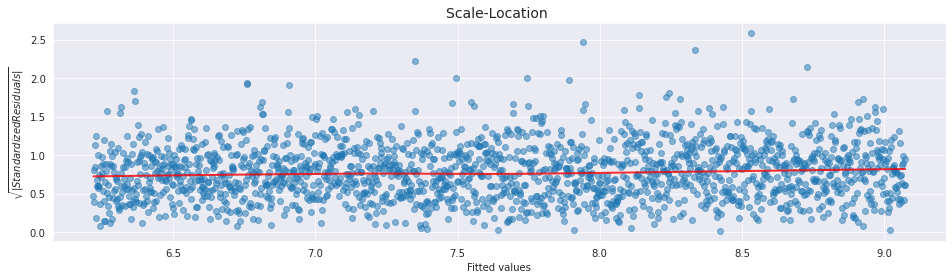

*** Koenker Test ***
Lagrange multiplier statistic:  5.585147145031185
p-value:  0.018113411397550877
Interpretation: Heteroscedasticity is present, the residuals are not distributed with equal variance (Ha)


In [126]:
scalelocationPlot(tbats_resid, figsize=(16,4))
checkHomoscedasticity(tbats_resid, robust=True)

##### Checking autocorrelation (TBATS residuals)

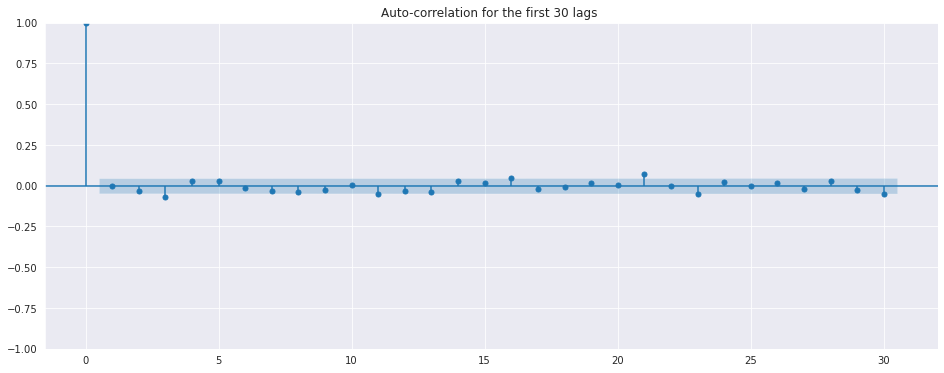

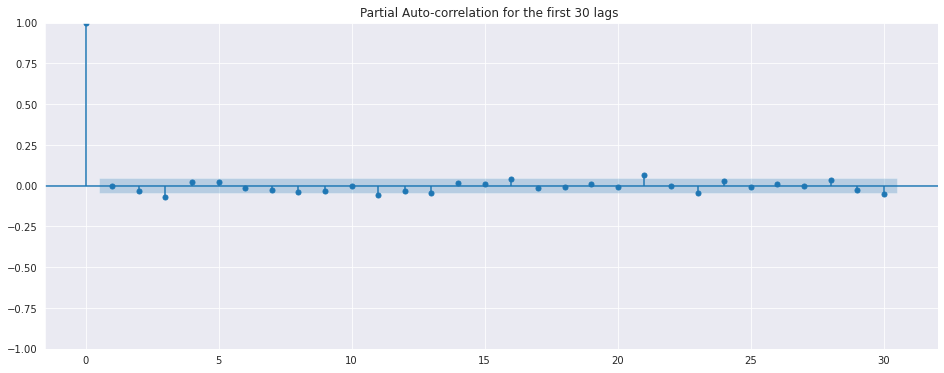

*** Ljung-Box Test [30 lags] ***
Q:  57.26617367231168
p-value:  0.0019475787276950873
Interpretation: The residuals are not independently distributed, they exhibit serial correlation (Ha)

*** Breusch-Godfrey Test [30 lags] ***
Lagrange multiplier statistic:  54.6413014595881
p-value:  0.003896716046997438
Interpretation: There exists autocorrelation at some order less than or equal to p (Ha)


In [127]:
autocorrelationPlot(tbats_resid, lags=30)
checkAutorcorrelation(tbats_resid, lags=30)

#### TBATS Prediction

In [128]:
y_pred_tbats =  tbats_fitted_model.forecast(steps=61)
y_pred_tbats = pd.Series(y_pred_tbats, index=test.index)

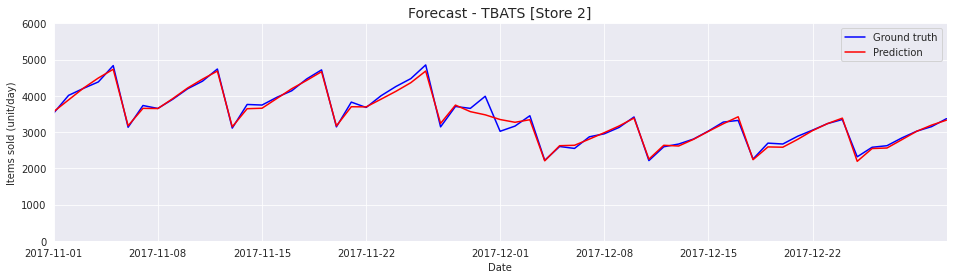

In [210]:
plt.figure(figsize=(16,4))
plt.plot(test, color='blue', label='Ground truth')
plt.plot(y_pred_tbats, color='red', label='Prediction')
plt.title('Forecast - TBATS [Store 2]', fontsize=14)
plt.xlim(test.index[0],test.index[-1])
plt.xlabel('Date')
plt.ylabel('Items sold (unit/day)')
plt.ylim(0,6000)
plt.legend()
plt.show()

In [240]:
mse_tbats = mean_squared_error(y_pred_tbats,test.values)
mae_tbats = mean_absolute_error(y_pred_tbats,test.values)
mape_tbats = mean_absolute_percentage_error(y_pred_tbats,test.values)*100

print('TBATS model performance: ')
print('MSE: ', round(mse_tbats,3))
print('MAE: ', round(mae_tbats,3))
print('MAPE: ', round(mape_tbats,3), '%')

TBATS model performance: 
MSE:  10951.74
MAE:  70.794
MAPE:  2.101 %


### Prophet

#### Mathematical description

The math of Prophet is really complex and hard to summarize in a paper like this. You can find details about it in:
> Taylor SJ, Letham B. 2017. *Forecasting at scale*. PeerJ Preprints 5:e3190v2 https://doi.org/10.7287/peerj.preprints.3190v2

#### Building the model

In [162]:
from prophet import Prophet

In [163]:
train_prophet = pd.DataFrame({'y':train.values,'ds':train.index.to_list()})
prophet_model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
prophet_fitted_model = prophet_model.fit(train_prophet)
future = prophet_fitted_model.make_future_dataframe(periods = 61)
forecast = prophet_fitted_model.predict(future)

Initial log joint probability = -31.0892
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5424.64    0.00285297       419.091           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5450.71    0.00309175       384.058           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5458.76    0.00135274       386.804      0.5317      0.5317      361   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     348       5460.53    0.00011152       288.833   5.735e-07       0.001      460  LS failed, Hessian reset 
     399       5460.97   0.000540566       166.527      0.3186      0.5975      530   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5462.26    0.00497952    

#### Checking the residuals

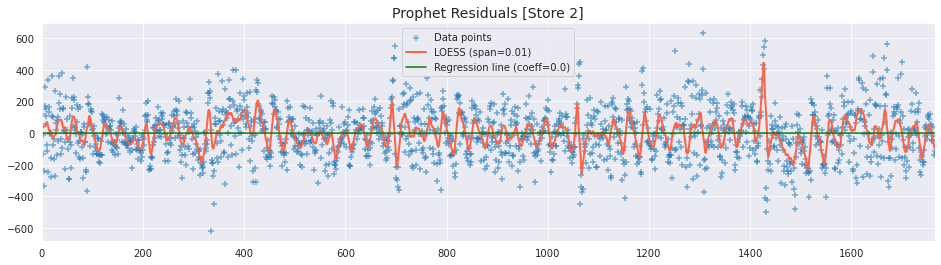

In [164]:
tmp = pd.merge(train_prophet, forecast.head(len(forecast)-61), on='ds')
prophet_resid = tmp['y'] - tmp['yhat']
plotTS(pd.DataFrame(prophet_resid, columns=['resid']), column='resid', figsize=(16,4), title='Prophet Residuals [Store 2]')

##### Checking normality (Prophet residuals)

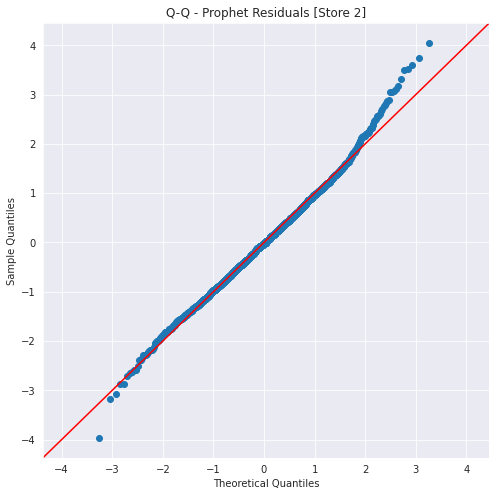

*** Shapiro-Wilk Test ***
W:  0.994931161403656
p-value:  1.0515016583667602e-05
Interpretation: the data was not drawn from a normal distribution (Ha)

*** Jarque-Bera Test ***
Jarque-Bera JB:  39.732113590534745
p-value:  2.3565743800801897e-09
Interpretation: the data was not drawn from a normal distribution (Ha)

*** D’Agostino-Pearson Test ***
k2:  30.928017090119486
p-value:  1.9233858680672415e-07
Interpretation: the data was not drawn from a normal distribution (Ha)

----------------------------------------------------------------------
Skewness:  0.2271404966746839
Kurtosis :  0.5778368969378129


In [165]:
qqPlot(prophet_resid, title='- Prophet Residuals [Store 2]')
checkNormality(prophet_resid)

##### Checking stationarity (Prophet residuals)

In [166]:
checkStationarity(prophet_resid, kpss_type='c')

*** ADF Test ***
ADF Statistic:  -7.510123357661531
p-value:  4.036246865078259e-11
Interpretation: The time series is stationary (Ha)

*** KPSS Test ***
KPSS Statistic: 0.03815917522268008
p-value:  0.1
Interpretation: The time series is stationary (Ho)


##### Checking homoscedasticity (Prophet residuals)

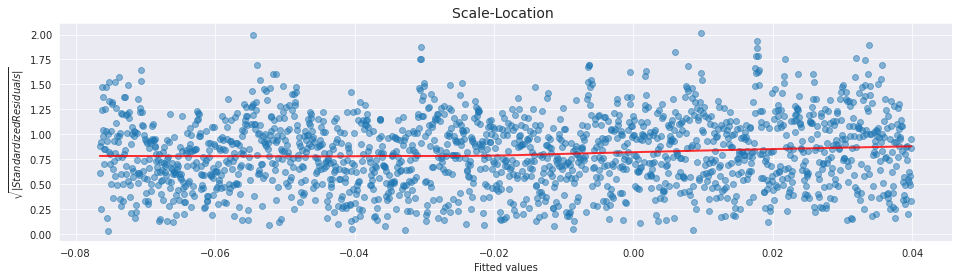

*** Koenker Test ***
Lagrange multiplier statistic:  20.15100731580613
p-value:  7.156255055134029e-06
Interpretation: Heteroscedasticity is present, the residuals are not distributed with equal variance (Ha)


In [167]:
scalelocationPlot(prophet_resid, figsize=(16,4))
checkHomoscedasticity(prophet_resid, robust=True)

##### Checking autocorrelation (Prophet residuals)

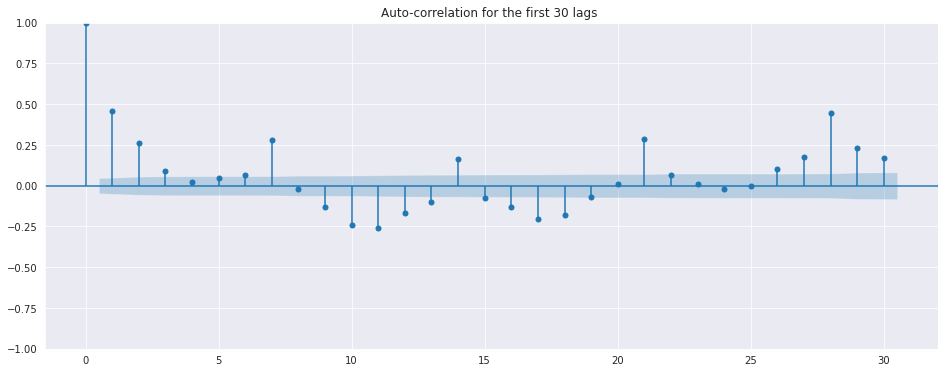

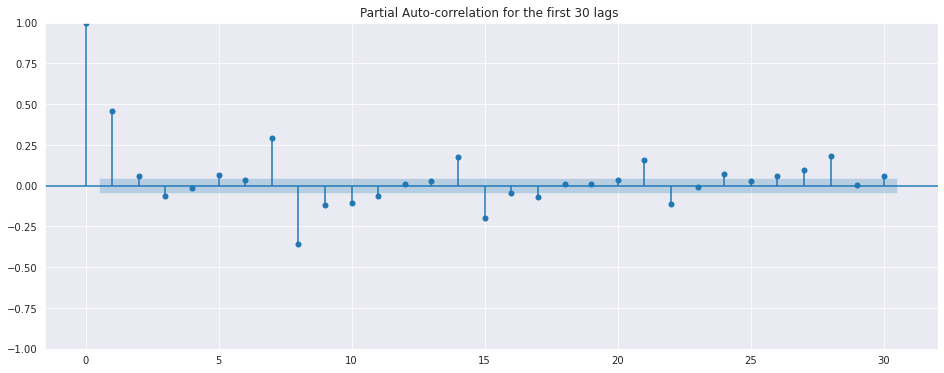

*** Ljung-Box Test [30 lags] ***
Q:  1937.0699135295094
p-value:  0.0
Interpretation: The residuals are not independently distributed, they exhibit serial correlation (Ha)

*** Breusch-Godfrey Test [30 lags] ***
Lagrange multiplier statistic:  869.1672676504347
p-value:  1.8600794085869438e-163
Interpretation: There exists autocorrelation at some order less than or equal to p (Ha)


In [168]:
autocorrelationPlot(prophet_resid, lags=30)
checkAutorcorrelation(prophet_resid, lags=30)

#### Prophet Prediction

In [182]:
y_pred_prophet = forecast['yhat'].tail(61)
y_pred_prophet.index = test.index

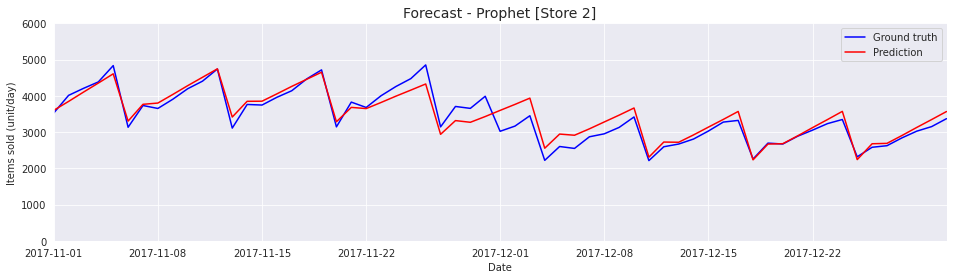

In [209]:
plt.figure(figsize=(16,4))
plt.plot(test, color='blue', label='Ground truth')
plt.plot(y_pred_prophet, color='red', label='Prediction')
plt.title('Forecast - Prophet [Store 2]', fontsize=14)
plt.xlim(test.index[0],test.index[-1])
plt.xlabel('Date')
plt.ylabel('Items sold (unit/day)')
plt.ylim(0,6000)
plt.legend()
plt.show()

In [241]:
mse_prophet = mean_squared_error(y_pred_prophet,test.values)
mae_prophet = mean_absolute_error(y_pred_prophet,test.values)
mape_prophet = mean_absolute_percentage_error(y_pred_prophet,test.values)*100

print('Prophet model performance: ')
print('MSE: ', round(mse_prophet,3))
print('MAE: ', round(mae_prophet,3))
print('MAPE: ', round(mape_prophet,3), '%')

Prophet model performance: 
MSE:  56107.683
MAE:  182.723
MAPE:  5.3 %


### Summary

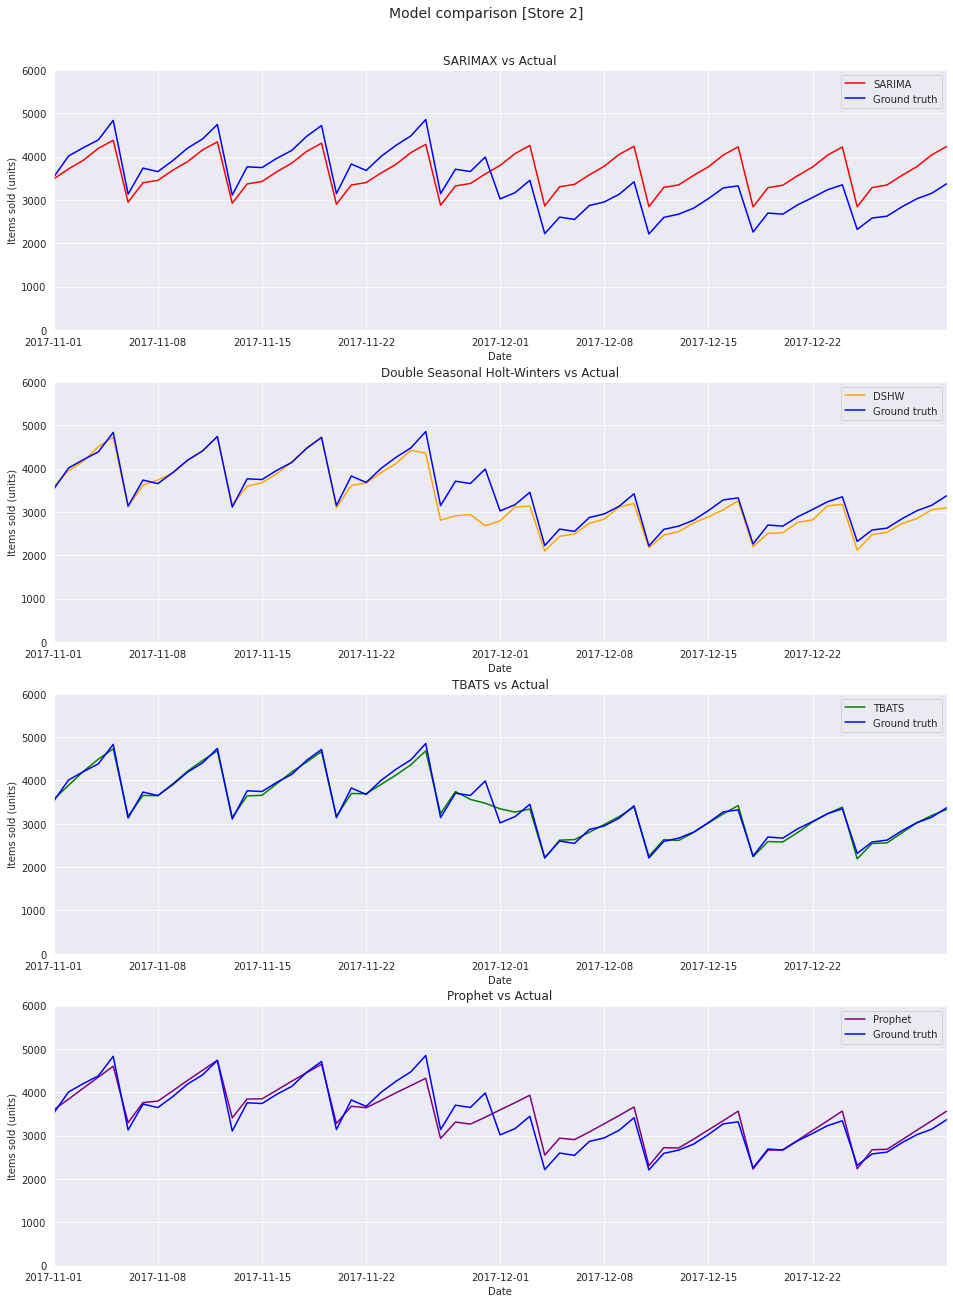

In [206]:
f, axes = plt.subplots(4,1,figsize=(16,22))
plt.suptitle('Model comparison [Store 2]', y=0.92, fontsize=14)

axes[0].plot(y_pred_arima, color='red', label='SARIMA')
axes[0].plot(test, color='blue', label='Ground truth')
axes[0].set_title('SARIMAX vs Actual', fontdict={'fontsize': 12})

axes[1].plot(y_pred_dshw, color='orange', label='DSHW')
axes[1].plot(test, color='blue', label='Ground truth')
axes[1].set_title('Double Seasonal Holt-Winters vs Actual', fontdict={'fontsize': 12})

axes[2].plot(y_pred_tbats, color='green', label='TBATS')
axes[2].plot(test, color='blue', label='Ground truth')
axes[2].set_title('TBATS vs Actual', fontdict={'fontsize': 12})

axes[3].plot(y_pred_prophet, color='purple', label='Prophet')
axes[3].plot(test, color='blue', label='Ground truth')
axes[3].set_title('Prophet vs Actual', fontdict={'fontsize': 12})

for a in axes:
    a.set_ylabel('Items sold (units)')
    a.set_xlabel('Date')
    a.set_xlim(test.index[0], test.index[-1])
    a.set_ylim(0,6000)
    a.legend()

plt.show()

In [243]:
data = {'Model':['SARIMA', 'DSHW', 'TBATS', 'PROPHET'],
        'MSE':[mse_sarimax, mse_dshw, mse_tbats, mse_prophet],
        'MAE':[mae_sarimax,mae_dshw,mae_tbats,mae_prophet],
        'MAPE (%)':[mape_sarimax,mape_dshw,mape_tbats,mape_prophet],
        'Stationarity (residuals)':['Stationary','Stationary','Stationary','Stationary'],
        'Distribution (residuals)':['Not normal','Not normal','Not normal','Not normal'],
        'Homoscedasticity (residuals)':['Homoscedastic','Heteroscedastic','Heteroscedastic','Heteroscedastic'],
        'Autocorrelation (residuals)':['Not autocorrelated','Not autocorrelated','Autocorrelated','Autocorrelated']}
 
all_models_summary = pd.DataFrame(data)
display(round(all_models_summary,2))

,Model,MSE,MAE,MAPE (%),Stationarity (residuals),Distribution (residuals),Homoscedasticity (residuals),Autocorrelation (residuals)
0,SARIMA,342571.21,535.48,14.72,Stationary,Not normal,Homoscedastic,Not autocorrelated
1,DSHW,68673.66,158.07,5.34,Stationary,Not normal,Heteroscedastic,Not autocorrelated
2,TBATS,10951.74,70.79,2.10,Stationary,Not normal,Heteroscedastic,Autocorrelated
3,PROPHET,56107.68,182.72,5.30,Stationary,Not normal,Heteroscedastic,Autocorrelated


# Forecast [All Store]